In [1]:
# Optional dependency check (avoid installing into /home on clusters)
import importlib.util
print("accelerate available:", importlib.util.find_spec("accelerate") is not None)


accelerate available: True


In [2]:
import os

# Fix cluster home quota: redirect caches (edit path if needed)
os.environ.setdefault("ROLE_REP_CACHE_DIR", f"/projects/JeFeSpace/KLM/cache/{os.environ.get('USER','user')}/role-rep")
os.environ.setdefault("HF_HOME", os.path.join(os.environ["ROLE_REP_CACHE_DIR"], "hf"))
os.environ.setdefault("HUGGINGFACE_HUB_CACHE", os.path.join(os.environ["HF_HOME"], "hub"))
os.environ.setdefault("TRANSFORMERS_CACHE", os.path.join(os.environ["HF_HOME"], "transformers"))
os.environ.setdefault("TORCH_HOME", os.path.join(os.environ["ROLE_REP_CACHE_DIR"], "torch"))
os.environ.setdefault("XDG_CACHE_HOME", os.path.join(os.environ["ROLE_REP_CACHE_DIR"], "xdg"))

# Avoid widget/progress-bar issues + HF xet
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["DISABLE_TQDM"] = "1"
os.environ["HF_HUB_DISABLE_XET"] = "1"

import getpass
if not (os.environ.get("HF_TOKEN") or os.environ.get("HUGGINGFACE_HUB_TOKEN")):
    os.environ["HF_TOKEN"] = getpass.getpass("HF token: ")
    os.environ["HUGGINGFACE_HUB_TOKEN"] = os.environ["HF_TOKEN"]

HF token:  ········


# Speaker Role Representation: Geometric Structure Analysis

**Goal:** Compare how two models (Qwen vs Llama) internally represent speaker identity in a long two‑person transcript.

We treat **speaker identity (Alice vs Bob)** as the concept and probe activations across layers and token positions.
Deliverables: PCA/t‑SNE, separability heatmaps, and concept directions.


**Question:** Do models maintain distinct internal representations for different speakers over a long conversation?

**Setup:** We build a long two‑person transcript (Alice vs Bob). Each token is labeled by the most recent speaker tag.
We extract hidden states across layers and token positions (speaker tag, subject tokens, verbs, final token).

**Analyses:**
- **Geometry:** PCA/t‑SNE plots show whether Alice and Bob tokens cluster.
- **Separability:** Linear classifiers measure how well a simple boundary separates speakers.
- **Concept direction:** Mean‑difference vectors test if a consistent "speaker axis" exists.

**Comparison:** Run the same pipeline on **Qwen** and **Llama** to compare where and how the concept emerges.

**Takeaway:** The layer and position with the cleanest separation indicate where speaker identity is most strongly encoded.


In [3]:
# %%capture
# Core
import json
import math
import os
import sys
from dataclasses import dataclass
from typing import Dict, List

# --- Cache + auth (prevents /home quota issues on clusters) ---
# You can override explicitly with ROLE_REP_CACHE_DIR.
ROLE_REP_CACHE_DIR = os.environ.get("ROLE_REP_CACHE_DIR")
if ROLE_REP_CACHE_DIR is None:
    user = os.environ.get("USER", "user")
    if os.path.isdir("/projects/JeFeSpace/KLM"):
        ROLE_REP_CACHE_DIR = f"/projects/JeFeSpace/KLM/cache/{user}/role-rep"
    elif os.path.isdir("/scratch"):
        ROLE_REP_CACHE_DIR = f"/scratch/{user}/role-rep-cache"

if ROLE_REP_CACHE_DIR:
    os.makedirs(ROLE_REP_CACHE_DIR, exist_ok=True)
    os.environ.setdefault("HF_HOME", os.path.join(ROLE_REP_CACHE_DIR, "hf"))
    os.environ.setdefault("HUGGINGFACE_HUB_CACHE", os.path.join(os.environ["HF_HOME"], "hub"))
    os.environ.setdefault("TRANSFORMERS_CACHE", os.path.join(os.environ["HF_HOME"], "transformers"))
    os.environ.setdefault("TORCH_HOME", os.path.join(ROLE_REP_CACHE_DIR, "torch"))
    os.environ.setdefault("XDG_CACHE_HOME", os.path.join(ROLE_REP_CACHE_DIR, "xdg"))

# Reduce notebook widget/progress issues
os.environ.setdefault("HF_HUB_DISABLE_PROGRESS_BARS", "1")
# Avoid HF "xet" download path (often problematic on clusters)
os.environ.setdefault("HF_HUB_DISABLE_XET", "1")

# If you installed packages into project space (e.g., accelerate), add that site-packages BEFORE importing transformers.
ROLE_REP_SITE_PACKAGES = os.environ.get(
    "ROLE_REP_SITE_PACKAGES",
    "/projects/JeFeSpace/KLM/pip_local/lib/python3.12/site-packages",
)
if os.path.isdir(ROLE_REP_SITE_PACKAGES) and ROLE_REP_SITE_PACKAGES not in sys.path:
    sys.path.insert(0, ROLE_REP_SITE_PACKAGES)


# If you exported HF_TOKEN/HUGGINGFACE_HUB_TOKEN in your shell, this will be picked up automatically.
HF_TOKEN = os.environ.get("HF_TOKEN") or os.environ.get("HUGGINGFACE_HUB_TOKEN")

# ML / viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Hugging Face
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Repro
np.random.seed(7)
torch.manual_seed(7)


/shared/EL9/explorer/anaconda3/2024.06/lib/python3.12/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
# Transcript: long two-person dialogue (Alice/Bob)
transcript_turns = [
    "Alice: Hey Bob, before we jump in, I wanted to revisit the design proposal.",
    "Bob: Sure, I skimmed it last night; the latency targets look ambitious.",
    "Alice: The client asked for sub-200ms p95; I think batching can get us there.",
    "Bob: Batching helps, but the cache invalidation could become tricky.",
    "Alice: We can constrain invalidation to product-level keys instead of per-user.",
    "Bob: That might reduce precision, though; would that impact personalization?",
    "Alice: Some, but we can re-rank on the client side for the top 10 results.",
    "Bob: Okay, so you are proposing a hybrid: coarse cache, fine rerank.",
    "Alice: Exactly. And we should log enough to measure drift each week.",
    "Bob: Logging is fine, but data retention policy caps at 30 days.",
    "Alice: Right, I can summarize weekly aggregates and delete raw events.",
    "Bob: Great. Also, the new API endpoint needs a version bump.",
    "Alice: v3 seems reasonable; we can keep v2 for a deprecation window.",
    "Bob: Then we need a migration guide; I can draft it.",
    "Alice: Thanks. Another point: the search index rebuild takes 6 hours.",
    "Bob: Maybe we can parallelize by shard and compress the postings lists.",
    "Alice: If we compress too much, we might slow decoding at query time.",
    "Bob: True; we could trade storage for CPU if latency budget allows.",
    "Alice: We'll benchmark both. Also, what about adding synonyms?",
    "Bob: Synonyms help recall, but they increase false positives.",
    "Alice: We'll tune the threshold and evaluate per-category.",
    "Bob: Sounds good. On another note, QA reported flaky tests.",
    "Alice: I saw that; I think the mock clock isn't resetting in CI.",
    "Bob: I can isolate those tests and add a fixture.",
    "Alice: Appreciate it. Lastly, are we aligned on the rollout plan?",
    "Bob: Staged rollout: internal, then 5% external, then 50%.",
    "Alice: And we monitor error rates and rollback if p95 spikes.",
    "Bob: Yes. I'll write the runbook.",
    "Alice: Great, I'll update the proposal and send it today.",
    "Bob: Perfect; I will review as soon as it lands.",
    "Alice: Thanks, Bob.",
    "Bob: Thanks, Alice."
]

transcript = "\n".join(transcript_turns)
transcript

# -----------------------------
# Controls / corruption variants
# -----------------------------
# We keep ground-truth speaker labels separate from the raw text so we can
# strip/mask speaker tags and apply lexical corruptions without losing labels.

import re
import numpy as np

_KNOWN_SPEAKERS = {"Alice", "Bob"}
_SPEAKER_PREFIX_RE = re.compile(r"^\s*(?P<speaker>[A-Za-z][A-Za-z0-9_ -]{0,30})\s*:\s*(?P<utt>.*)$")
_WORD_RE = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

# A lightweight list of function words (used if no POS tagger is available).
_FUNCTION_WORDS = {
    "a", "an", "the", "this", "that", "these", "those",
    "i", "you", "he", "she", "it", "we", "they", "me", "him", "her", "us", "them",
    "my", "your", "his", "her", "its", "our", "their",
    "and", "or", "but", "if", "then", "so", "because", "though", "while", "as",
    "to", "of", "in", "on", "at", "for", "with", "from", "by", "about", "into", "over", "under",
    "is", "am", "are", "was", "were", "be", "been", "being",
    "do", "does", "did", "doing",
    "have", "has", "had", "having",
    "will", "would", "can", "could", "should", "may", "might", "must",
    "not", "no", "yes",
}

_AUX_VERBS = {
    "am", "is", "are", "was", "were", "be", "been", "being",
    "do", "does", "did", "doing",
    "have", "has", "had", "having",
    "will", "would", "can", "could", "should", "may", "might", "must",
}

# Matches the notebook's original "verb" list plus common auxiliaries.
_DEFAULT_VERB_LEXICON = {
    "am", "will", "can", "should", "think", "like", "want",
    *list(_AUX_VERBS),
}


def split_speaker_prefix(turn: str) -> tuple[str, str]:
    """Return (speaker, utterance_text). Speaker is 'Unknown' if no known prefix."""
    m = _SPEAKER_PREFIX_RE.match(turn)
    if not m:
        return "Unknown", turn
    sp = m.group("speaker")
    utt = m.group("utt")
    if sp in _KNOWN_SPEAKERS:
        return sp, utt
    return "Unknown", turn


def strip_name_tag(turn: str) -> str:
    """Remove leading 'Alice:'/'Bob:' from a turn (if present)."""
    _sp, utt = split_speaker_prefix(turn)
    return utt


def mask_name_tag_constant(turn: str, mask: str = "Speaker") -> str:
    """Replace any leading known speaker tag with a constant mask tag."""
    sp, utt = split_speaker_prefix(turn)
    if sp in _KNOWN_SPEAKERS:
        return f"{mask}: {utt}"
    return turn


def _replace_words(text: str, should_replace, replace_with) -> str:
    """Regex-safe word replacement preserving punctuation/spacing."""
    out = []
    last = 0
    for m in _WORD_RE.finditer(text):
        w = m.group(0)
        out.append(text[last : m.start()])
        out.append(replace_with(w) if should_replace(w) else w)
        last = m.end()
    out.append(text[last:])
    return "".join(out)


def _is_verbish(word: str, verb_lexicon: set[str]) -> bool:
    w = word.lower()
    if w in verb_lexicon:
        return True
    # crude morphology fallback
    if w.endswith("ing") or w.endswith("ed"):
        return True
    return False


def mask_verbs(text: str, mask_token: str = "<VERB>", verb_lexicon: set[str] | None = None) -> str:
    """Replace verb-like words with a mask token."""
    verb_lexicon = verb_lexicon or _DEFAULT_VERB_LEXICON
    return _replace_words(text, lambda w: _is_verbish(w, verb_lexicon), lambda _w: mask_token)


def keep_only_verbs(text: str, verb_lexicon: set[str] | None = None, empty_token: str = "<NO_VERBS>") -> str:
    verb_lexicon = verb_lexicon or _DEFAULT_VERB_LEXICON
    verbs = [m.group(0) for m in _WORD_RE.finditer(text) if _is_verbish(m.group(0), verb_lexicon)]
    return " ".join(verbs) if verbs else empty_token


def keep_only_function_words(text: str, empty_token: str = "<NO_FUNCTION_WORDS>") -> str:
    fws = [m.group(0) for m in _WORD_RE.finditer(text) if m.group(0).lower() in _FUNCTION_WORDS]
    return " ".join(fws) if fws else empty_token


def keep_only_nounish_content(text: str, verb_lexicon: set[str] | None = None, empty_token: str = "<NO_NOUNISH>") -> str:
    """Heuristic stand-in for nouns/props: non-function, non-verb words."""
    verb_lexicon = verb_lexicon or _DEFAULT_VERB_LEXICON
    nouns = [
        m.group(0)
        for m in _WORD_RE.finditer(text)
        if (m.group(0).lower() not in _FUNCTION_WORDS) and (not _is_verbish(m.group(0), verb_lexicon))
    ]
    return " ".join(nouns) if nouns else empty_token


def replace_verbs_with_random(
    text: str,
    rng: np.random.Generator,
    verb_pool: list[str],
    verb_lexicon: set[str] | None = None,
) -> str:
    """Replace verb-like words with random verbs matched (roughly) by character length."""
    verb_lexicon = verb_lexicon or _DEFAULT_VERB_LEXICON
    if not verb_pool:
        return text

    by_len: dict[int, list[str]] = {}
    for v in verb_pool:
        by_len.setdefault(len(v), []).append(v)
    lens = sorted(by_len.keys())

    def sample_same_len(w: str) -> str:
        L = len(w)
        if L in by_len:
            cand = by_len[L]
        else:
            # closest available length
            closest = min(lens, key=lambda x: abs(x - L))
            cand = by_len[closest]
        v = cand[int(rng.integers(0, len(cand)))]
        return v.capitalize() if w[:1].isupper() else v

    return _replace_words(text, lambda w: _is_verbish(w, verb_lexicon), sample_same_len)


def build_variants(turns_with_tags: list[str], seed: int = 7) -> dict[str, dict]:
    rng = np.random.default_rng(seed)

    turn_speakers = [split_speaker_prefix(t)[0] for t in turns_with_tags]
    turns_stripped = [strip_name_tag(t) for t in turns_with_tags]

    # verb pool for random replacement
    verb_pool = sorted(
        {
            m.group(0).lower()
            for t in turns_stripped
            for m in _WORD_RE.finditer(t)
            if _is_verbish(m.group(0), _DEFAULT_VERB_LEXICON)
        }
    )
    verb_pool = verb_pool or sorted(_DEFAULT_VERB_LEXICON)

    # 1) Name-tag removal/masking
    v_strip = {
        "turns": turns_stripped,
        "turn_speakers": turn_speakers,
        "notes": "Remove 'Alice:'/'Bob:' prefixes; keep labels from original turns.",
    }
    v_mask = {
        "turns": [mask_name_tag_constant(t, mask="Speaker") for t in turns_with_tags],
        "turn_speakers": turn_speakers,
        "notes": "Replace speaker tag with constant 'Speaker:' prefix.",
    }

    # 2) Speaker-label shuffle (negative control): keep text fixed, permute labels
    shuffled_labels = turn_speakers.copy()
    rng.shuffle(shuffled_labels)
    v_label_shuffle = {
        "turns": turns_stripped,
        "turn_speakers": shuffled_labels,
        "notes": "Permute speaker labels across turns; text unchanged.",
    }

    # 3) Turn-order corruption
    perm = rng.permutation(len(turns_stripped))
    v_turn_shuffle_dialogue = {
        "turns": [turns_stripped[i] for i in perm],
        "turn_speakers": [turn_speakers[i] for i in perm],
        "notes": "Shuffle turn order within the dialogue (turn text and label permuted together).",
    }

    # Shuffle within speaker while preserving the original speaker sequence pattern.
    idx_by_sp: dict[str, list[int]] = {"Alice": [], "Bob": [], "Unknown": []}
    for i, sp in enumerate(turn_speakers):
        idx_by_sp.setdefault(sp, []).append(i)

    turns_within = turns_stripped.copy()
    for sp, idxs in idx_by_sp.items():
        if len(idxs) <= 1:
            continue
        permuted_utts = [turns_stripped[i] for i in idxs]
        rng.shuffle(permuted_utts)
        for j, i in enumerate(idxs):
            turns_within[i] = permuted_utts[j]

    v_turn_shuffle_within_speaker = {
        "turns": turns_within,
        "turn_speakers": turn_speakers,
        "notes": "Permute each speaker's utterances across their own turns (keeps speaker alternation pattern).",
    }

    # 4) Lexical corruption (applied after stripping tags)
    v_mask_verbs = {
        "turns": [mask_verbs(t) for t in turns_stripped],
        "turn_speakers": turn_speakers,
        "notes": "Mask verb-like words with <VERB>.",
    }
    v_only_verbs = {
        "turns": [keep_only_verbs(t) for t in turns_stripped],
        "turn_speakers": turn_speakers,
        "notes": "Keep only verbs (heuristic); replace empty with <NO_VERBS>.",
    }
    v_only_function = {
        "turns": [keep_only_function_words(t) for t in turns_stripped],
        "turn_speakers": turn_speakers,
        "notes": "Keep only function words (stopword-style list).",
    }
    v_only_nounish = {
        "turns": [keep_only_nounish_content(t) for t in turns_stripped],
        "turn_speakers": turn_speakers,
        "notes": "Keep only 'noun-ish' content words (non-function, non-verb heuristic).",
    }
    v_replace_verbs_random = {
        "turns": [replace_verbs_with_random(t, rng=rng, verb_pool=verb_pool) for t in turns_stripped],
        "turn_speakers": turn_speakers,
        "notes": "Replace verb-like words with random verbs matched by character length.",
    }

    return {
        "baseline": {"turns": turns_with_tags, "turn_speakers": turn_speakers, "notes": "Original text with explicit speaker tags."},
        "strip_name_tags": v_strip,
        "mask_name_tags": v_mask,
        "speaker_label_shuffle": v_label_shuffle,
        "turn_shuffle_within_dialogue": v_turn_shuffle_dialogue,
        "turn_shuffle_within_speaker": v_turn_shuffle_within_speaker,
        "mask_verbs": v_mask_verbs,
        "only_verbs": v_only_verbs,
        "only_function_words": v_only_function,
        "only_nounish_content": v_only_nounish,
        "replace_verbs_random": v_replace_verbs_random,
    }


VARIANTS = build_variants(transcript_turns, seed=7)
list(VARIANTS.keys())

['baseline',
 'strip_name_tags',
 'mask_name_tags',
 'speaker_label_shuffle',
 'turn_shuffle_within_dialogue',
 'turn_shuffle_within_speaker',
 'mask_verbs',
 'only_verbs',
 'only_function_words',
 'only_nounish_content',
 'replace_verbs_random']

In [5]:
# Model config: Qwen 7B + Qwen 2.5 + Llama 3.1 8B
# These are HF names; swap to local paths if you have them.

MODEL_NAMES = {
    "qwen_7b": os.environ.get("QWEN_7B_MODEL", "Qwen/Qwen2-7B-Instruct"),
    "qwen_2_5": os.environ.get("QWEN_25_MODEL", "Qwen/Qwen2.5-7B-Instruct"),
    # NOTE: official HF repo name often includes "Meta-" prefix
    "llama_3_1_8b": os.environ.get("LLAMA_31_8B_MODEL", "meta-llama/Meta-Llama-3.1-8B-Instruct"),
}

# Some clusters ship an older transformers that can't parse Llama-3.1 rope_scaling.
# This shim overrides rope_scaling into the older (type,factor) format so the model can load.
MODEL_LOAD_KWARGS = {
    "llama_3_1_8b": {
        "rope_scaling": {"type": "linear", "factor": 8.0},
    }
}

# Layers to probe: 0, 25%, 50%, 75%, 100%
LAYER_FRACTIONS = [0.0, 0.25, 0.5, 0.75, 1.0]

# Token positions to probe
# NOTE: For speaker tags, tokenization differs (Llama uses sentencepiece), so we locate them by
# matching token-id subsequences rather than string matching.
POSITION_SPECS = {
    "final": {"type": "final"},
    "speaker_tag": {"type": "speaker_tag", "values": ["Alice", "Bob"]},
    "verb": {"type": "string", "values": ["am", "will", "can", "should", "think", "like", "want"]},
}


In [6]:
@dataclass
class ModelBundle:
    name: str
    tokenizer: AutoTokenizer
    model: AutoModelForCausalLM


def _best_dtype():
    # Use bf16 on A100/H100 when available; otherwise fall back.
    if torch.cuda.is_available():
        try:
            major, _minor = torch.cuda.get_device_capability(0)
            if major >= 8:  # Ampere+
                return torch.bfloat16
        except Exception:
            pass
        return torch.float16
    return torch.float32


def _load_llama_config_with_rope_compat(model_id: str, cache_dir: str | None):
    """Patch Llama-3.1 rope_scaling for older transformers.

    Older `transformers` expects `rope_scaling` to be exactly:
      {"type": <str>, "factor": <float>}
    Llama-3.1 config uses a richer schema (rope_type/low_freq_factor/etc.).
    """
    import json
    from transformers.utils import cached_file
    from transformers.models.llama.configuration_llama import LlamaConfig

    cfg_path = cached_file(model_id, "config.json", cache_dir=cache_dir, token=HF_TOKEN)
    with open(cfg_path, "r") as f:
        cfg = json.load(f)

    rs = cfg.get("rope_scaling")
    if isinstance(rs, dict) and ("type" not in rs) and ("rope_type" in rs):
        cfg["rope_scaling"] = {"type": "linear", "factor": float(rs.get("factor", 8.0))}

    # Build a concrete config object directly (AutoConfig.from_dict may not exist on older installs)
    return LlamaConfig(**cfg)


def load_model(name: str, model_kwargs: Dict | None = None) -> ModelBundle:
    import importlib.util

    cache_dir = os.environ.get("TRANSFORMERS_CACHE") or os.environ.get("HF_HOME")
    dtype = _best_dtype()
    model_kwargs = model_kwargs or {}

    tokenizer = AutoTokenizer.from_pretrained(
        name,
        cache_dir=cache_dir,
        token=HF_TOKEN,
    )

    have_accelerate = importlib.util.find_spec("accelerate") is not None
    device_map = "auto" if (torch.cuda.is_available() and have_accelerate) else None
    low_cpu_mem_usage = True if have_accelerate else False

    try:
        model = AutoModelForCausalLM.from_pretrained(
            name,
            cache_dir=cache_dir,
            device_map=device_map,
            torch_dtype=dtype,
            low_cpu_mem_usage=low_cpu_mem_usage,
            token=HF_TOKEN,
            **model_kwargs,
        )
    except ValueError as e:
        # Handle Llama-3.1 rope_scaling schema mismatch on older transformers
        if "rope_scaling" in str(e) and "type" in str(e) and "factor" in str(e):
            cfg = _load_llama_config_with_rope_compat(name, cache_dir)
            model = AutoModelForCausalLM.from_pretrained(
                name,
                cache_dir=cache_dir,
                config=cfg,
                device_map=device_map,
                torch_dtype=dtype,
                low_cpu_mem_usage=low_cpu_mem_usage,
                token=HF_TOKEN,
            )
        else:
            raise

    if torch.cuda.is_available() and device_map is None:
        model = model.to("cuda")

    model.config.output_hidden_states = True
    model.eval()

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    return ModelBundle(name=name, tokenizer=tokenizer, model=model)


def select_layers(num_layers: int, fractions: List[float]) -> List[int]:
    indices = []
    for f in fractions:
        idx = int(round(f * num_layers))
        idx = max(0, min(num_layers, idx))
        indices.append(idx)
    return sorted(list(dict.fromkeys(indices)))


def _find_subsequence_positions(sequence: List[int], pattern: List[int]) -> List[int]:
    if not pattern or len(pattern) > len(sequence):
        return []
    out = []
    m = len(pattern)
    for i in range(len(sequence) - m + 1):
        if sequence[i : i + m] == pattern:
            out.append(i)
    return out


def _norm_token(t: str) -> str:
    # Works for GPT2 BPE (Ġ) and sentencepiece (▁)
    return t.strip().lstrip("Ġ").lstrip("▁").strip().lower()


def find_positions(tokens: List[str], spec: Dict, tokenizer=None, input_ids=None) -> List[int]:
    t = spec["type"]

    if t == "final":
        return [len(tokens) - 1]

    if t == "speaker_tag":
        if tokenizer is None or input_ids is None:
            return []
        seq = input_ids[0].tolist() if hasattr(input_ids, "shape") else list(input_ids)
        positions = []
        for name in spec.get("values", []):
            pat = tokenizer.encode(name, add_special_tokens=False)
            positions.extend(_find_subsequence_positions(seq, pat))
        return sorted(list(dict.fromkeys(positions)))

    if t == "string":
        values = {v.lower() for v in spec.get("values", [])}
        hits = [i for i, tok in enumerate(tokens) if _norm_token(tok) in values]
        return hits

    return []


def label_speakers(tokens: List[str], raw_text: str) -> np.ndarray:
    labels = []
    last_speaker = None
    cursor = 0

    for tok in tokens:
        window = raw_text[cursor: cursor + 200]
        if "Alice:" in window and ("Bob:" not in window or window.index("Alice:") < window.index("Bob:")):
            last_speaker = "Alice"
        if "Bob:" in window and ("Alice:" not in window or window.index("Bob:") < window.index("Alice:")):
            last_speaker = "Bob"

        labels.append(last_speaker if last_speaker else "Unknown")

        tok_clean = tok.replace("Ġ", " ")
        if tok_clean in raw_text[cursor:]:
            cursor = raw_text.index(tok_clean, cursor) + len(tok_clean)
        else:
            cursor = min(cursor + max(1, len(tok_clean)), len(raw_text))

    return np.array(labels)


In [7]:
def _build_input_ids_and_labels(
    tokenizer,
    turns: List[str],
    turn_speakers: list[str] | None = None,
):
    """Tokenize turn-by-turn to get robust speaker labels across tokenizers.

    IMPORTANT: `turn_speakers` is the ground-truth label per turn and should be provided
    for corruption/ablation variants where the raw text may not include 'Alice:'/'Bob:'.

    If `turn_speakers` is None, we fall back to inferring labels from turn prefixes.
    """
    all_ids: List[int] = []
    all_labels: List[str] = []

    for i, turn in enumerate(turns):
        if turn_speakers is not None:
            sp = turn_speakers[i] if i < len(turn_speakers) else "Unknown"
        else:
            if turn.startswith("Alice:"):
                sp = "Alice"
            elif turn.startswith("Bob:"):
                sp = "Bob"
            else:
                sp = "Unknown"

        ids = tokenizer(turn, add_special_tokens=False).input_ids
        all_ids.extend(ids)
        all_labels.extend([sp] * len(ids))

        # Add newline separator between turns
        if i < len(turns) - 1:
            nl_ids = tokenizer("\n", add_special_tokens=False).input_ids
            all_ids.extend(nl_ids)
            all_labels.extend([sp] * len(nl_ids))

    input_ids = torch.tensor([all_ids], dtype=torch.long)
    attention_mask = torch.ones_like(input_ids)
    labels = np.array(all_labels)
    return input_ids, attention_mask, labels


def run_analysis_for_model(
    bundle: ModelBundle,
    turns: list[str],
    turn_speakers: list[str] | None = None,
    *,
    variant_key: str = "baseline",
) -> Dict:
    tokenizer = bundle.tokenizer
    model = bundle.model

    input_ids, attention_mask, speaker_labels = _build_input_ids_and_labels(
        tokenizer, turns, turn_speakers=turn_speakers
    )

    # Move inputs to the model device when possible
    device = next(model.parameters()).device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True,
        )

    hidden_states = outputs.hidden_states
    if hidden_states is None:
        raise RuntimeError("Model did not return hidden states; ensure output_hidden_states=True")

    num_layers = len(hidden_states) - 1
    layer_indices = select_layers(num_layers, LAYER_FRACTIONS)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].detach().cpu())
    positions = {
        name: find_positions(tokens, spec, tokenizer=tokenizer, input_ids=input_ids.detach().cpu())
        for name, spec in POSITION_SPECS.items()
    }

    data = {}
    for layer in layer_indices:
        hs = hidden_states[layer][0].detach().cpu().numpy()  # [seq_len, hidden_dim]
        for pos_name, pos_indices in positions.items():
            pos_indices = [p for p in pos_indices if p < hs.shape[0]]
            if not pos_indices:
                continue
            X = hs[pos_indices]
            y = speaker_labels[pos_indices]
            mask = np.isin(y, ["Alice", "Bob"])
            X = X[mask]
            y = y[mask]
            if len(y) < 4:
                continue
            data[(layer, pos_name)] = (X, y)

    return {
        "model_name": bundle.name,
        "variant_key": variant_key,
        "tokens": tokens,
        "layers": layer_indices,
        "positions": positions,
        "speaker_labels": speaker_labels,
        "data": data,
    }


In [8]:
# Run analysis model-by-model (avoids loading all 7B/8B models at once)

# Running every corruption for every model can be expensive.
# Start with a manageable subset; switch to `list(VARIANTS.keys())` when ready.
VARIANT_KEYS_TO_RUN = [
    "baseline",
    "strip_name_tags",
    "mask_name_tags",
    "speaker_label_shuffle",
    "turn_shuffle_within_dialogue",
    "turn_shuffle_within_speaker",
    "mask_verbs",
    "only_verbs",
    "only_function_words",
    "replace_verbs_random",
]

results = {}  # model_key -> variant_key -> result
for model_key, name in MODEL_NAMES.items():
    print(f"Loading {model_key}: {name}")
    bundle = load_model(name, model_kwargs=MODEL_LOAD_KWARGS.get(model_key))
    try:
        results[model_key] = {}
        for variant_key in VARIANT_KEYS_TO_RUN:
            v = VARIANTS[variant_key]
            print(f"  Variant: {variant_key}")
            results[model_key][variant_key] = run_analysis_for_model(
                bundle,
                v["turns"],
                v.get("turn_speakers"),
                variant_key=variant_key,
            )
    finally:
        # Free GPU/CPU memory before next model
        try:
            del bundle.model
        except Exception:
            pass
        del bundle
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

list(results.keys())

Loading qwen_7b: Qwen/Qwen2-7B-Instruct


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


  Variant: baseline
  Variant: strip_name_tags
  Variant: mask_name_tags
  Variant: speaker_label_shuffle
  Variant: turn_shuffle_within_dialogue
  Variant: turn_shuffle_within_speaker
  Variant: mask_verbs
  Variant: only_verbs
  Variant: only_function_words
  Variant: replace_verbs_random
Loading qwen_2_5: Qwen/Qwen2.5-7B-Instruct


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  Variant: baseline
  Variant: strip_name_tags
  Variant: mask_name_tags
  Variant: speaker_label_shuffle
  Variant: turn_shuffle_within_dialogue
  Variant: turn_shuffle_within_speaker
  Variant: mask_verbs
  Variant: only_verbs
  Variant: only_function_words
  Variant: replace_verbs_random
Loading llama_3_1_8b: meta-llama/Meta-Llama-3.1-8B-Instruct


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


  Variant: baseline
  Variant: strip_name_tags
  Variant: mask_name_tags
  Variant: speaker_label_shuffle
  Variant: turn_shuffle_within_dialogue
  Variant: turn_shuffle_within_speaker
  Variant: mask_verbs
  Variant: only_verbs
  Variant: only_function_words
  Variant: replace_verbs_random


['qwen_7b', 'qwen_2_5', 'llama_3_1_8b']

['qwen_7b', 'qwen_2_5', 'llama_3_1_8b']

Loading qwen_2_5: Qwen/Qwen2.5-7B-Instruct


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


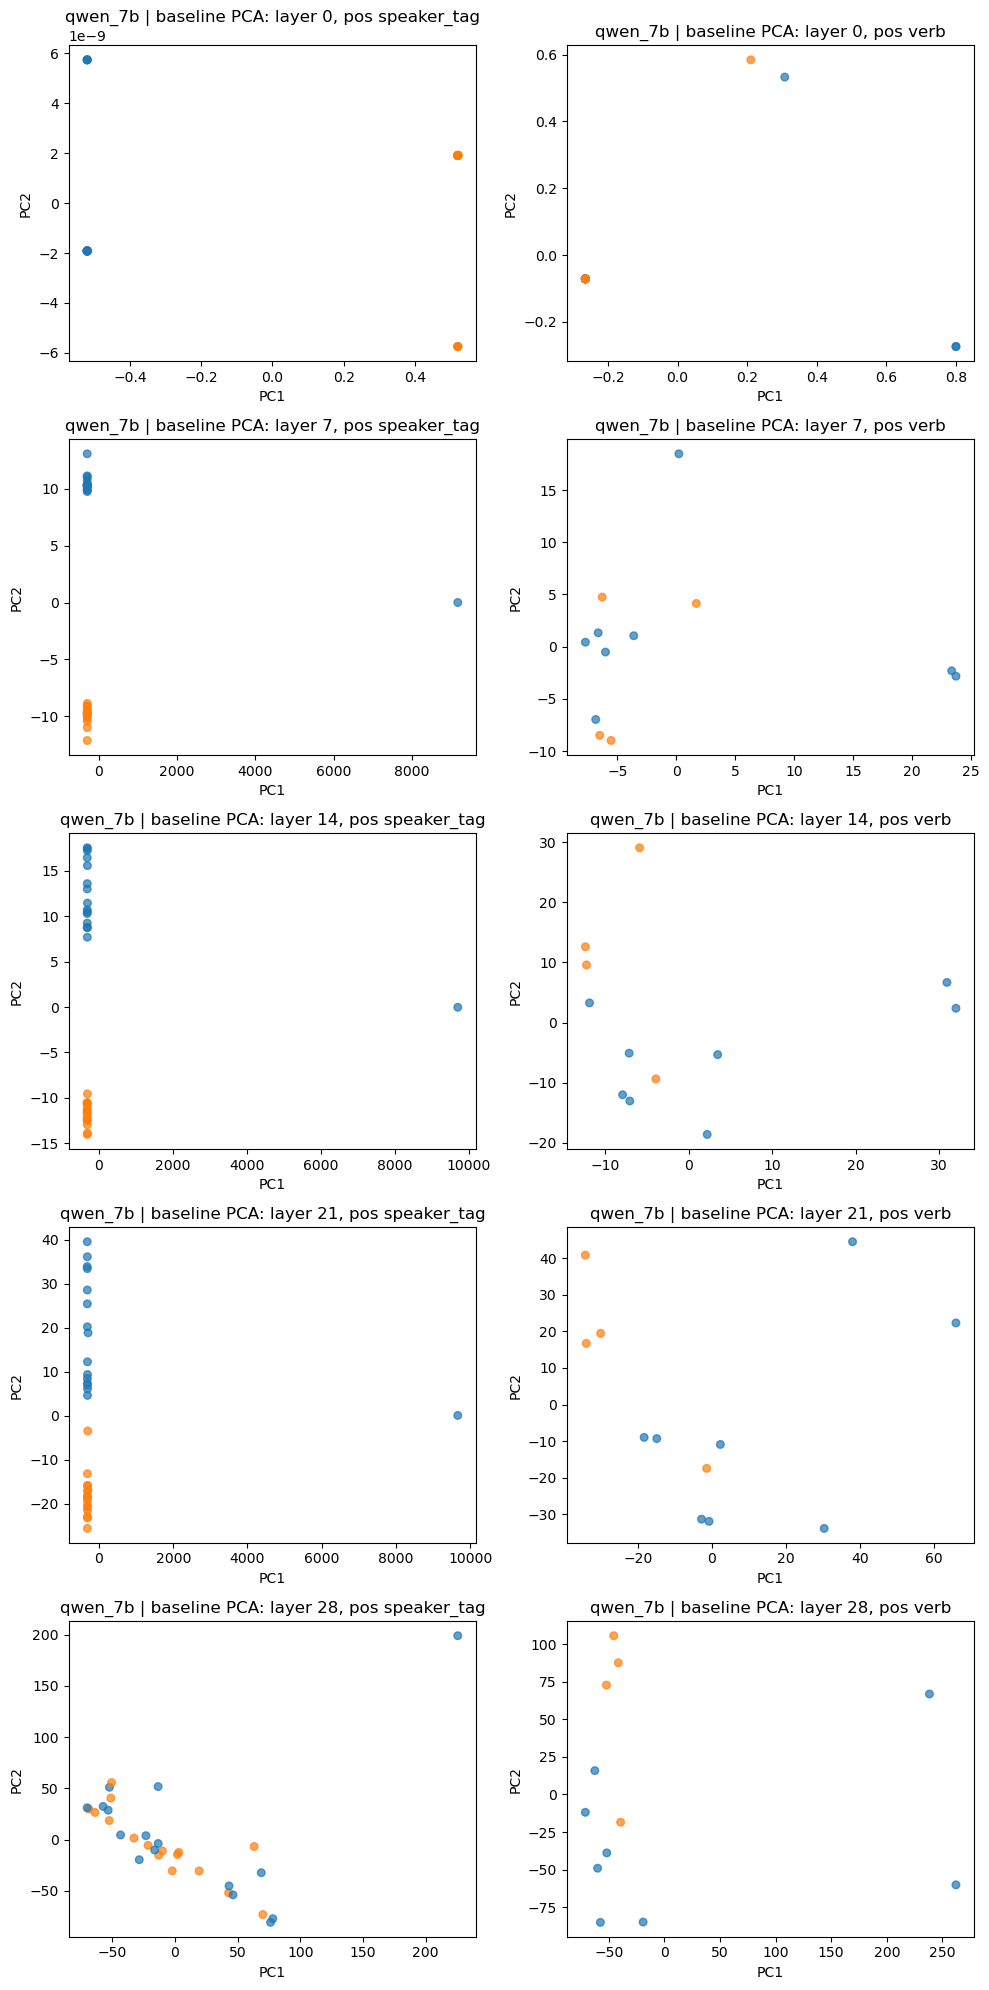

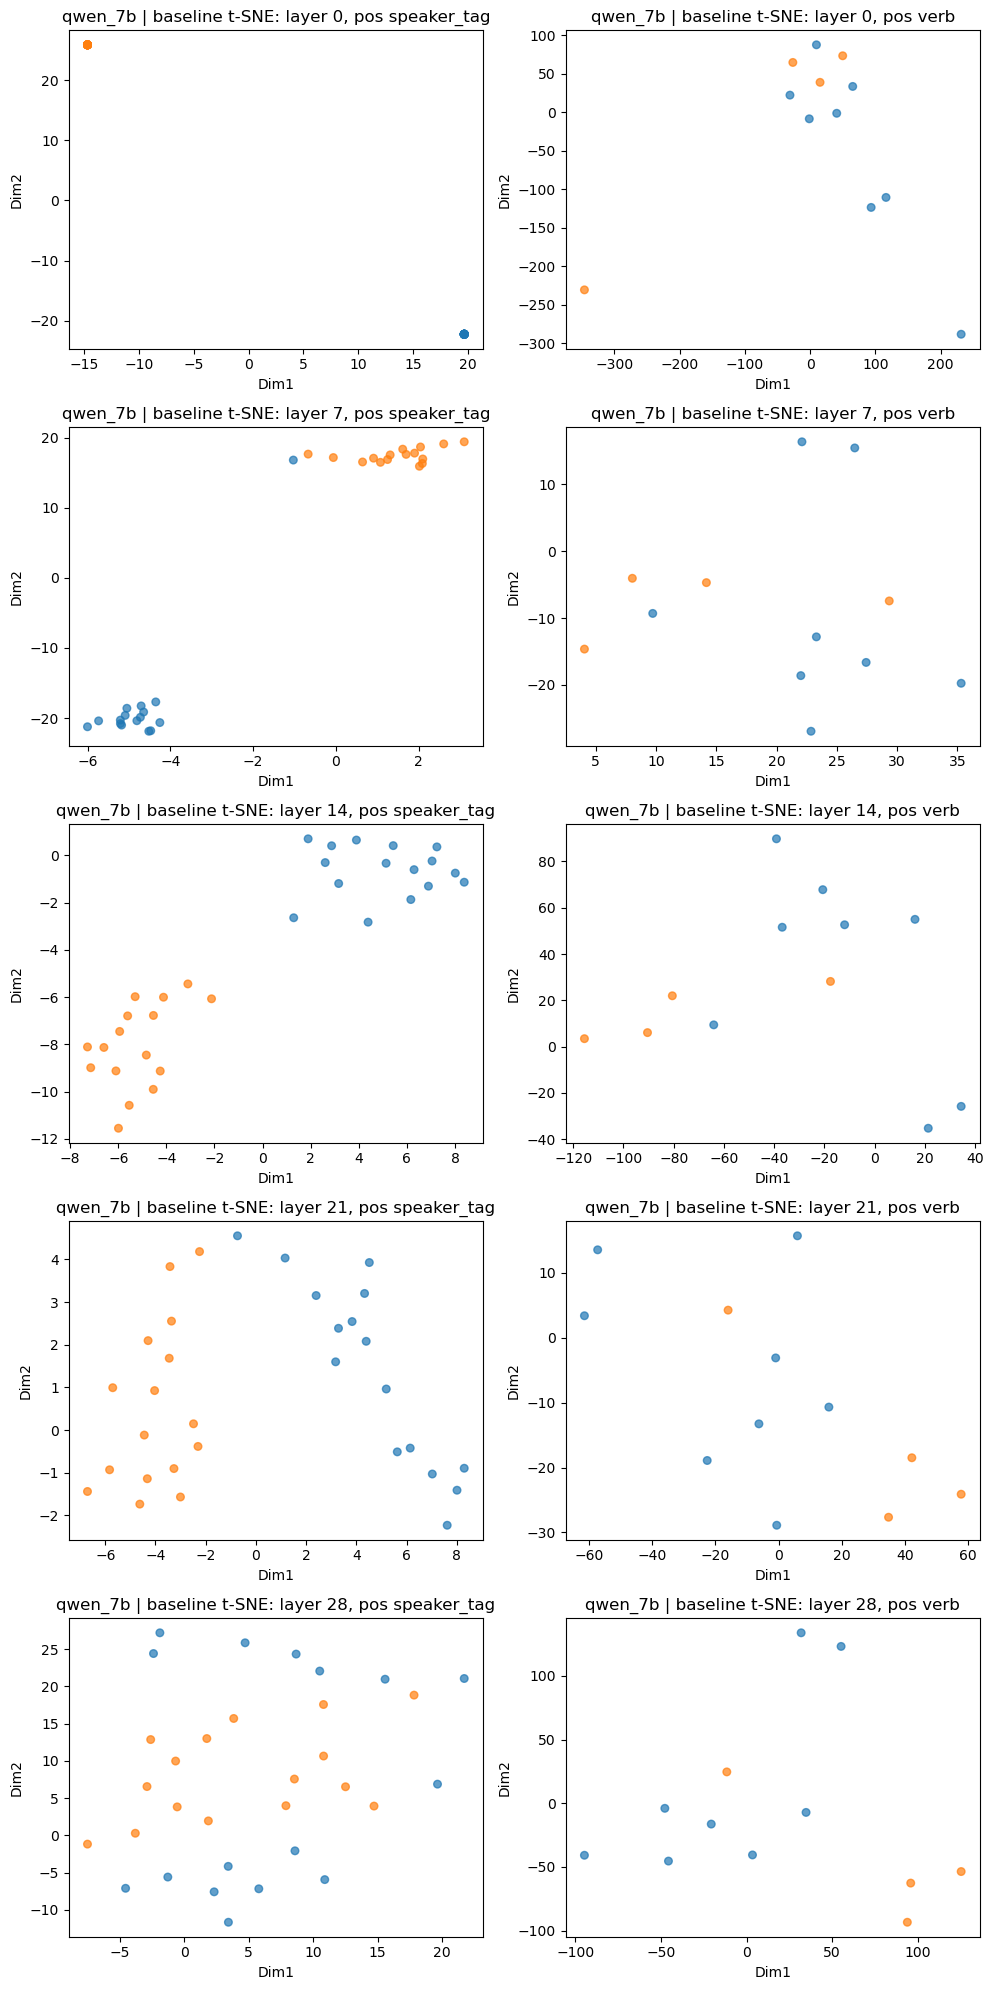

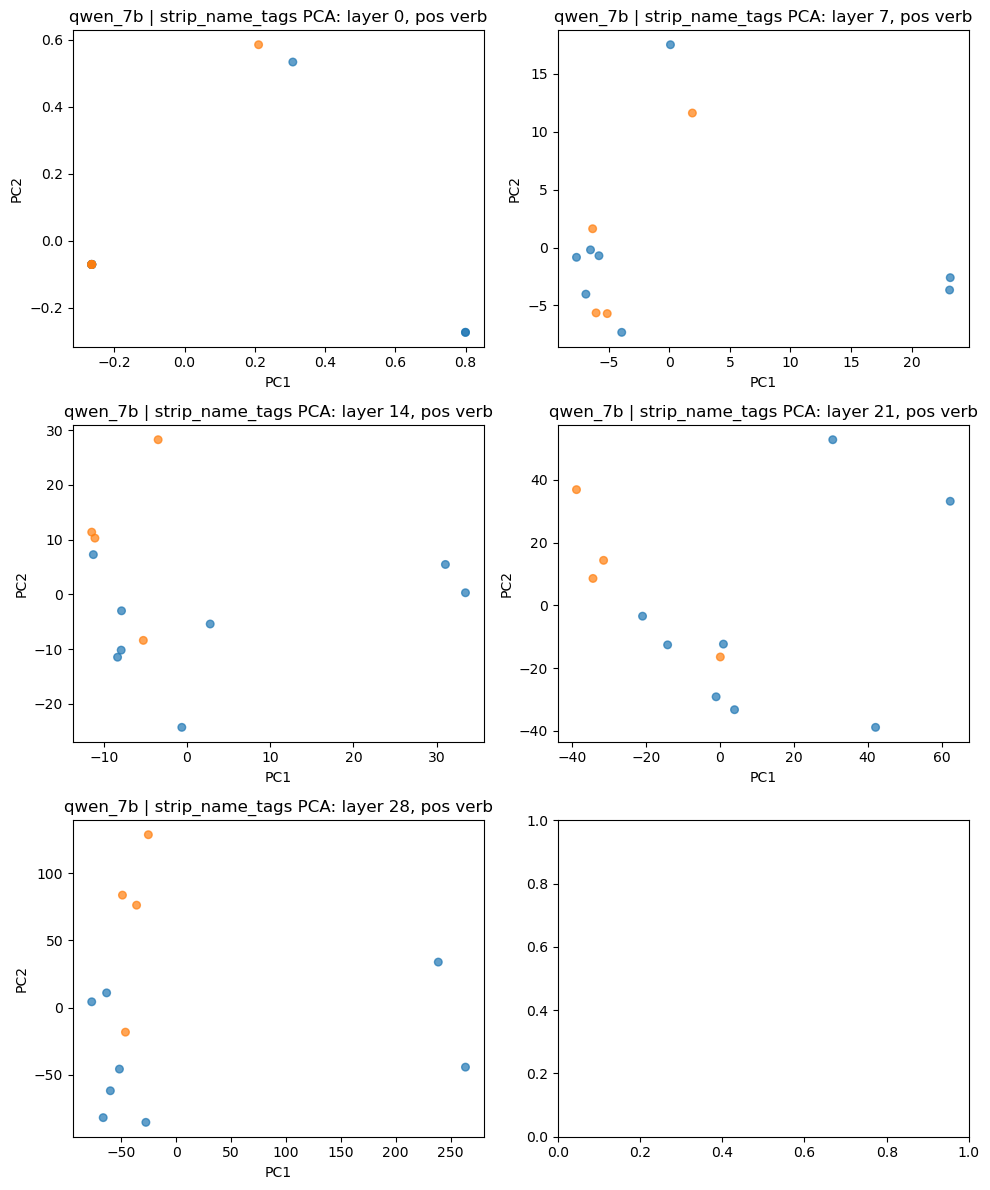

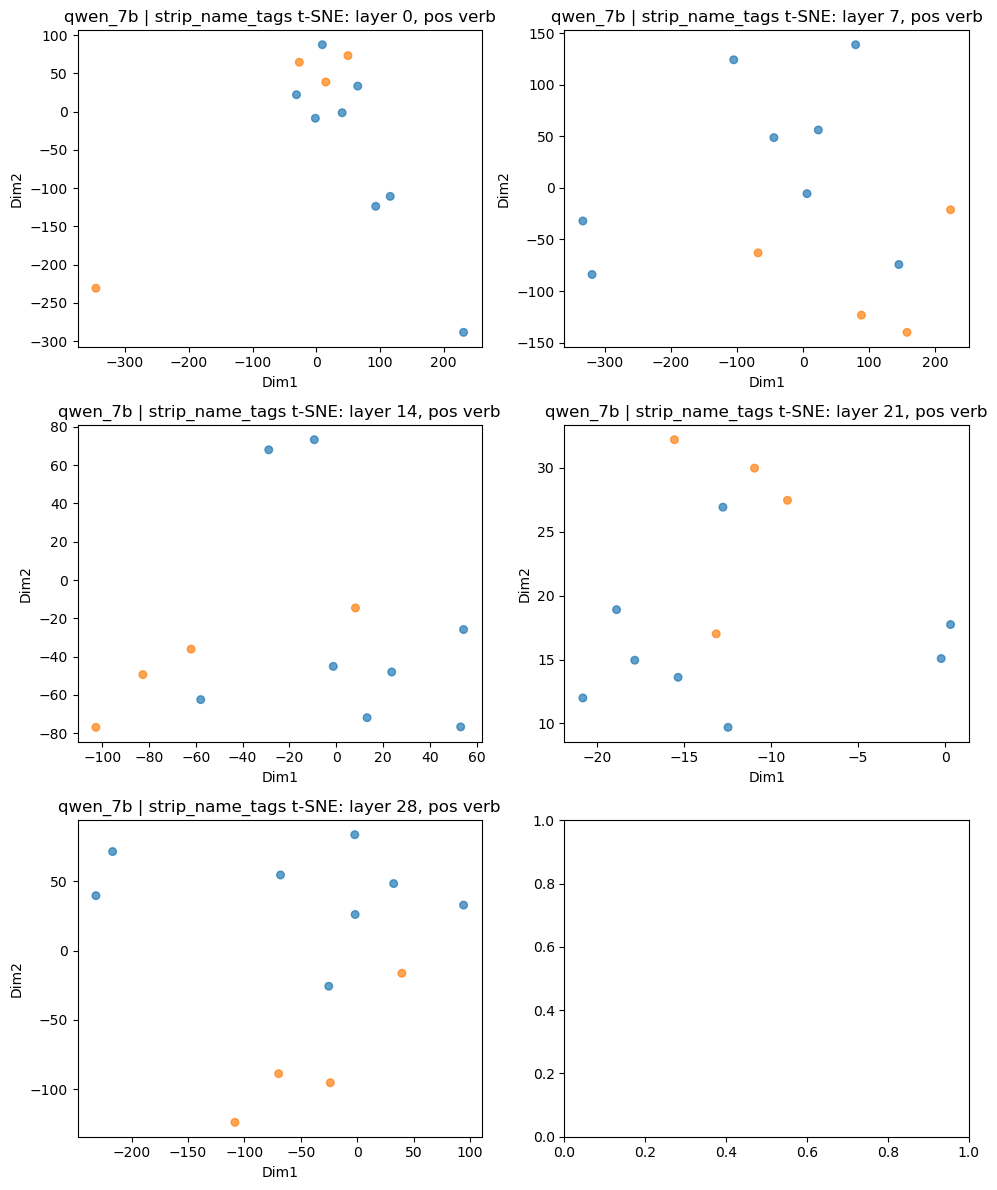

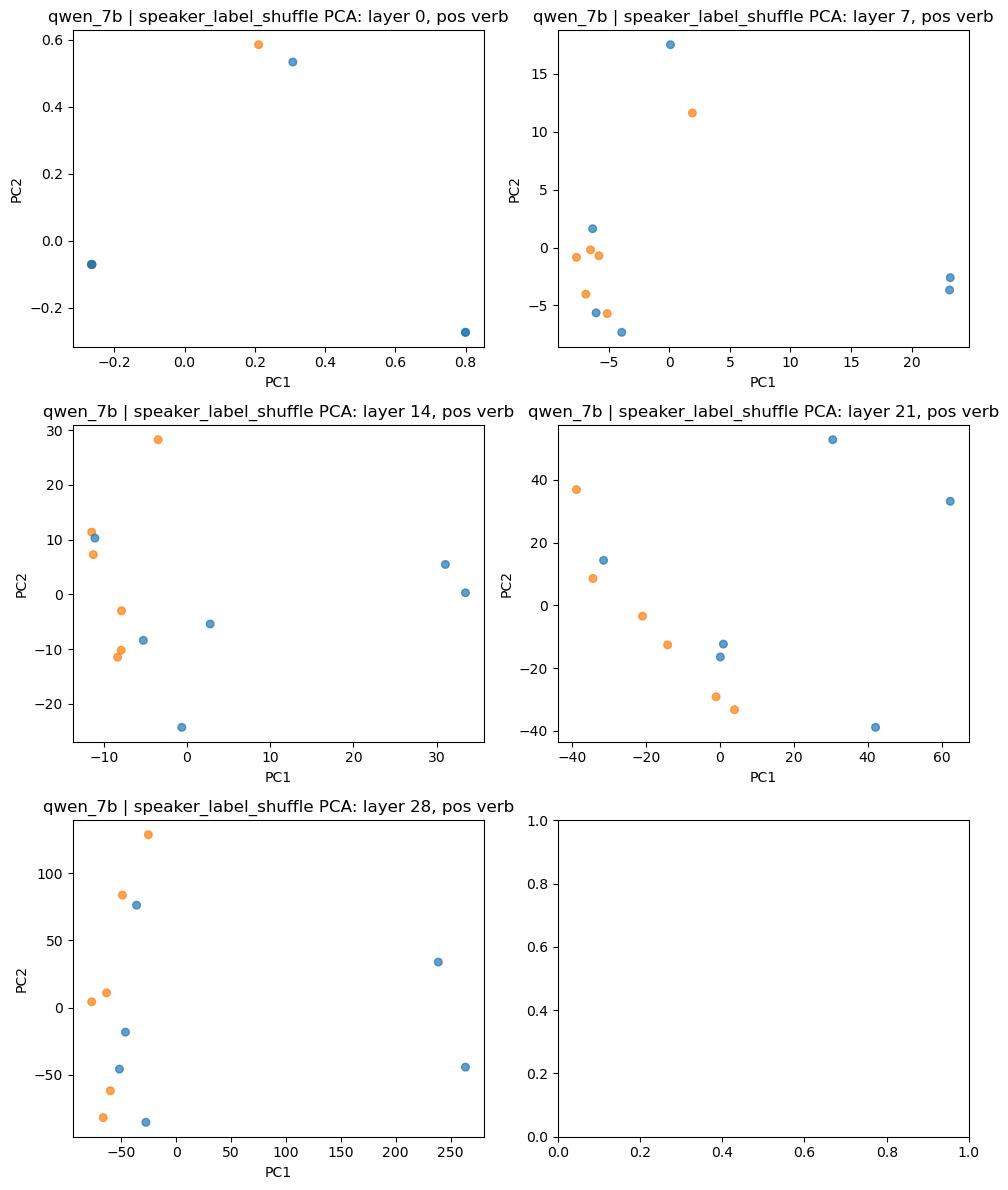

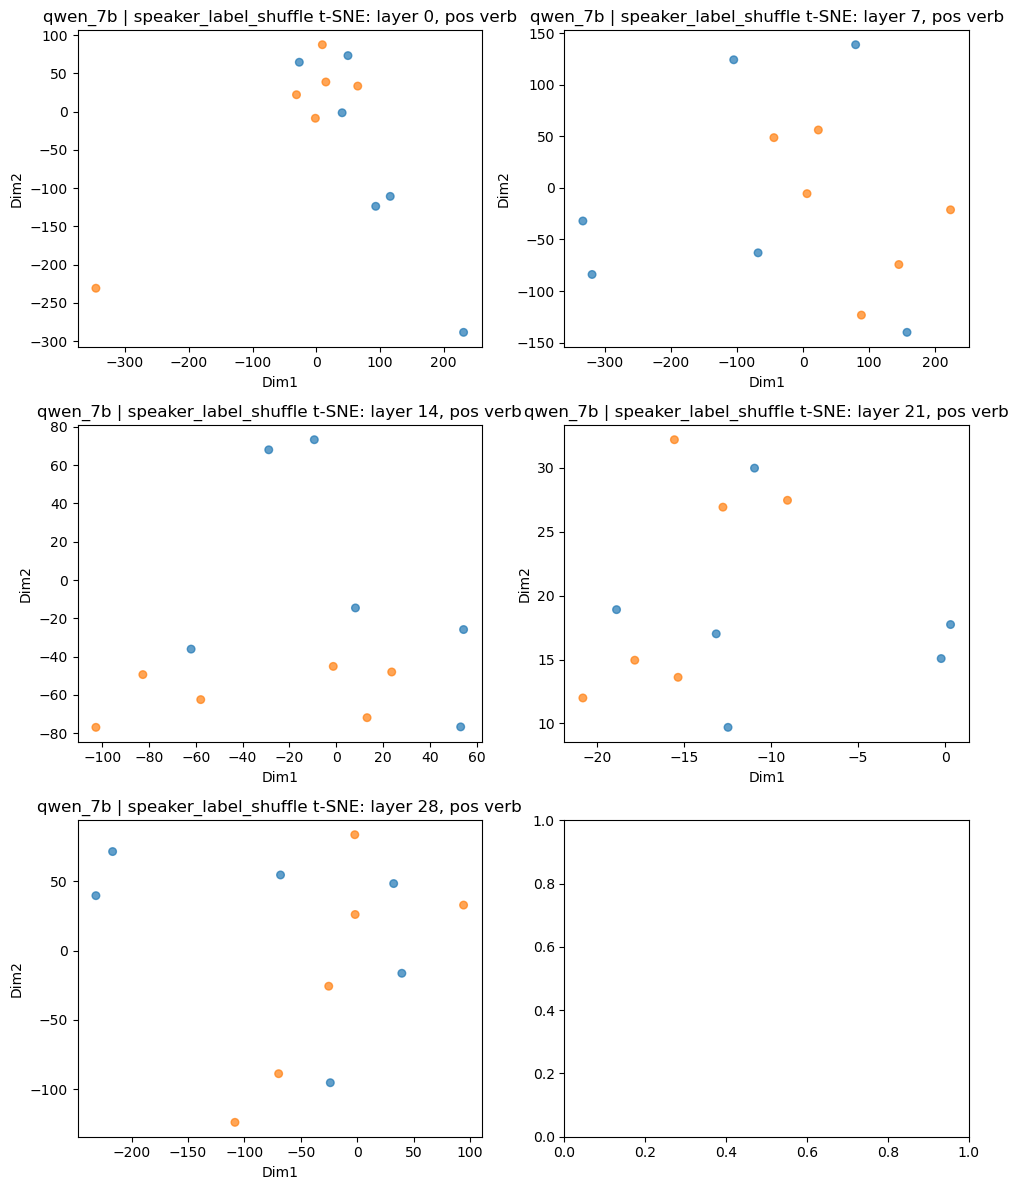

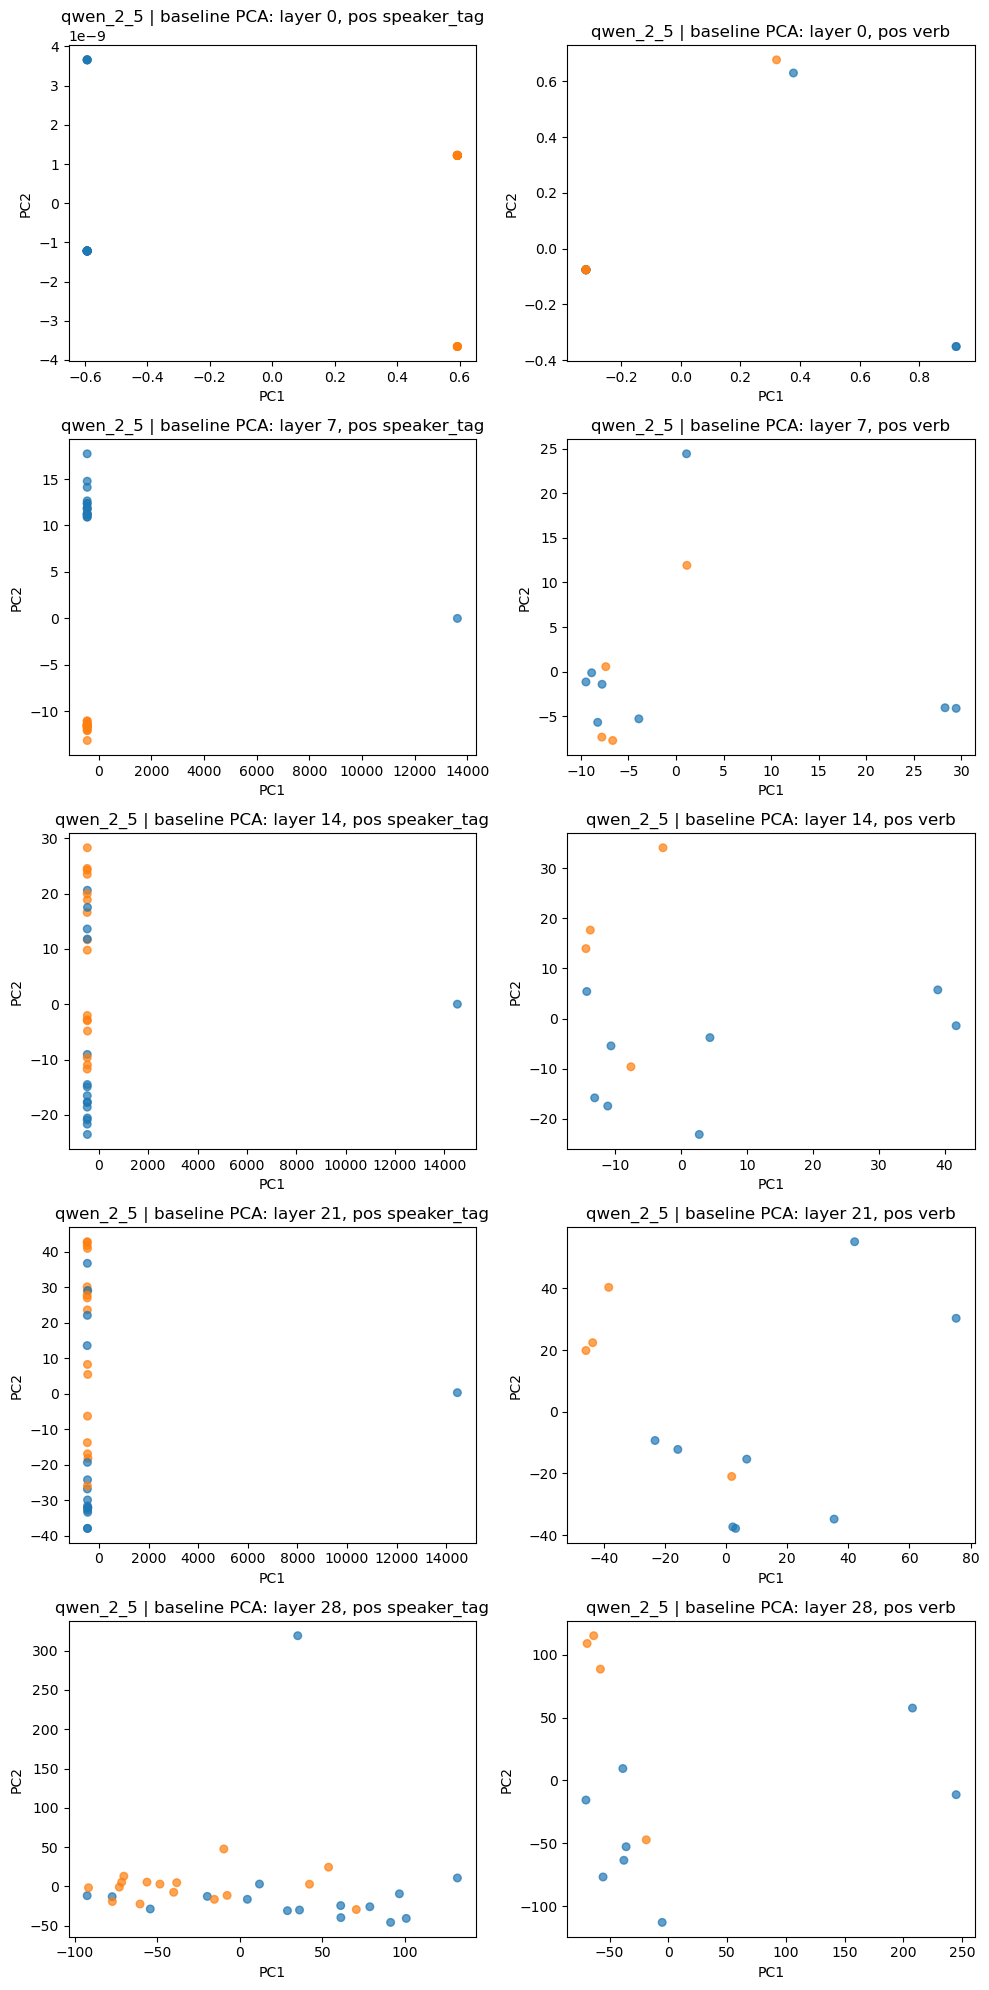

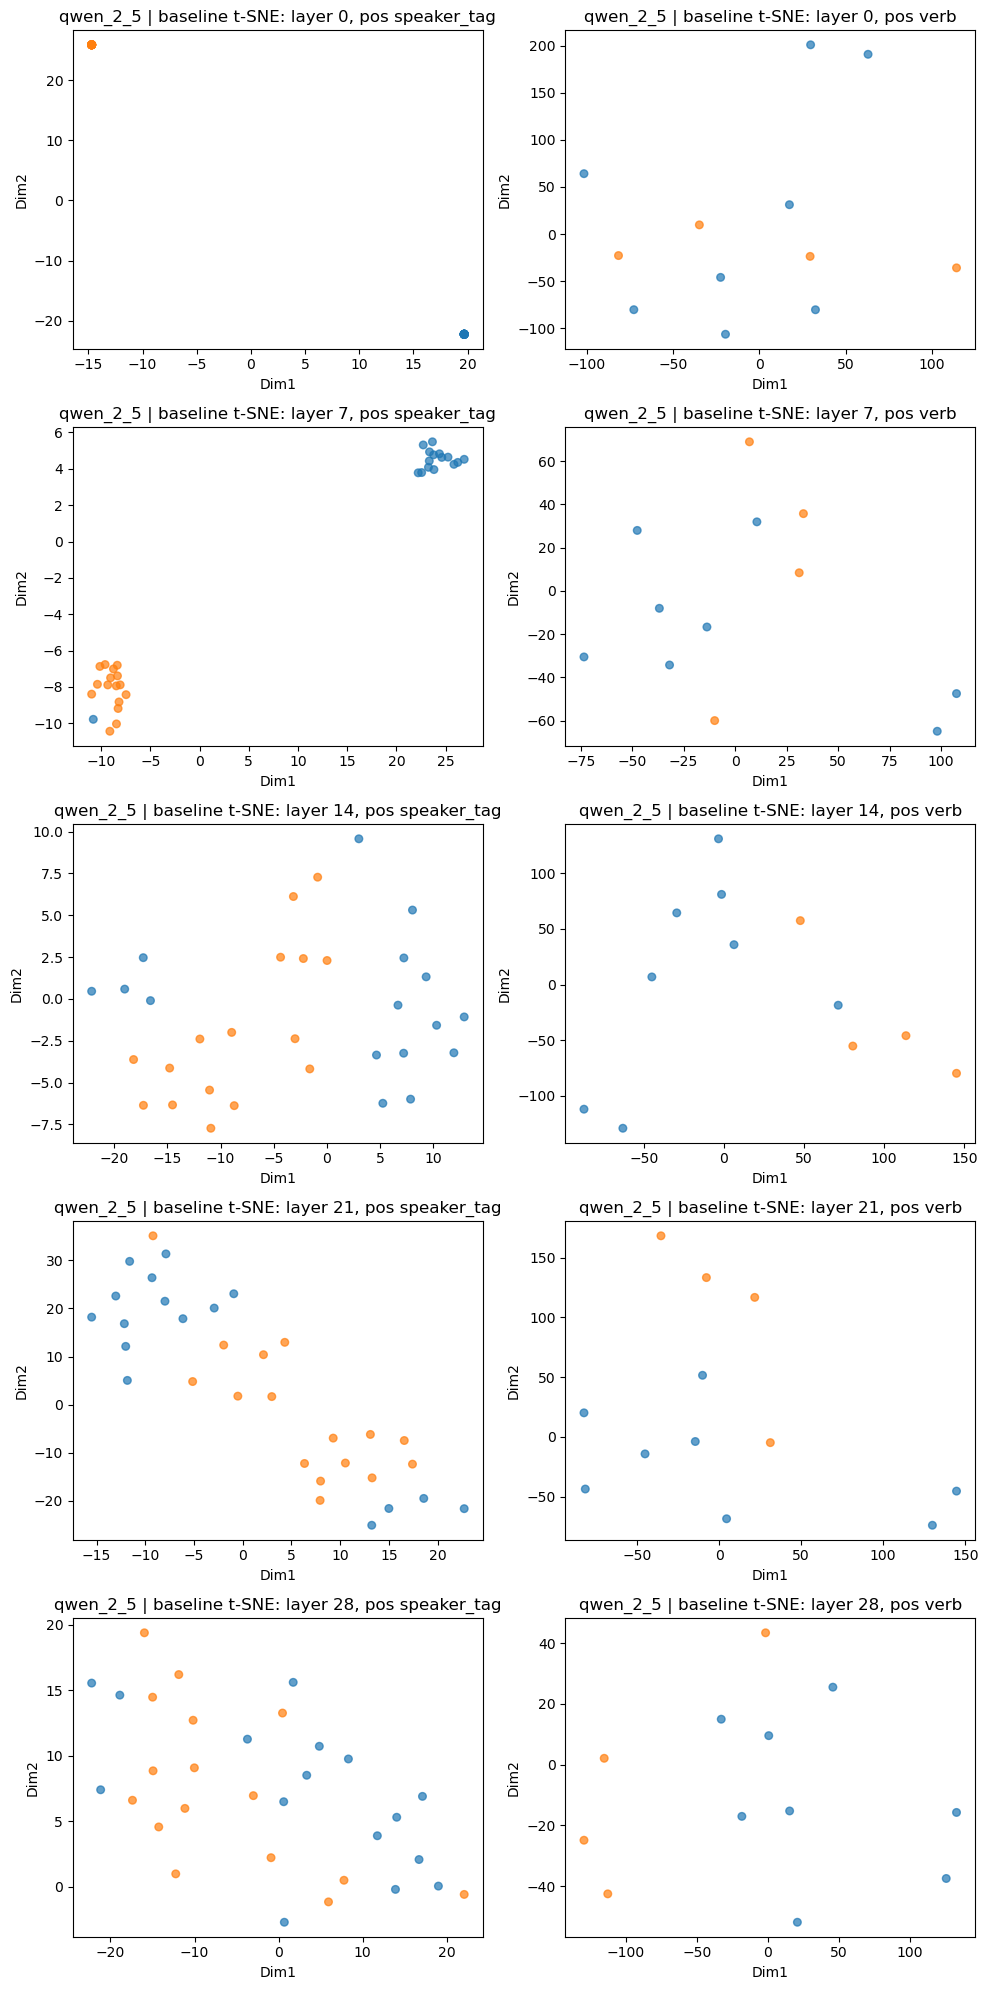

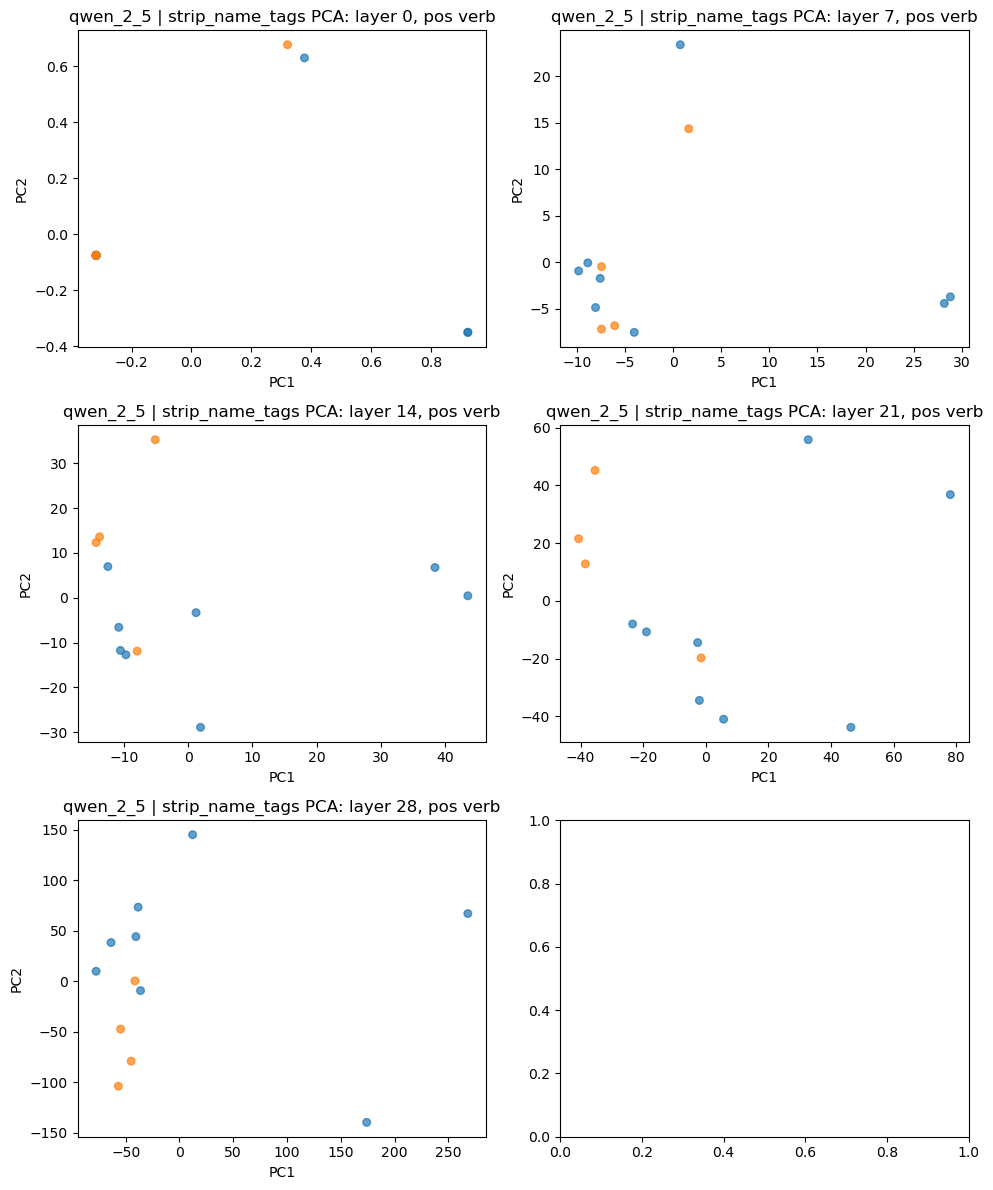

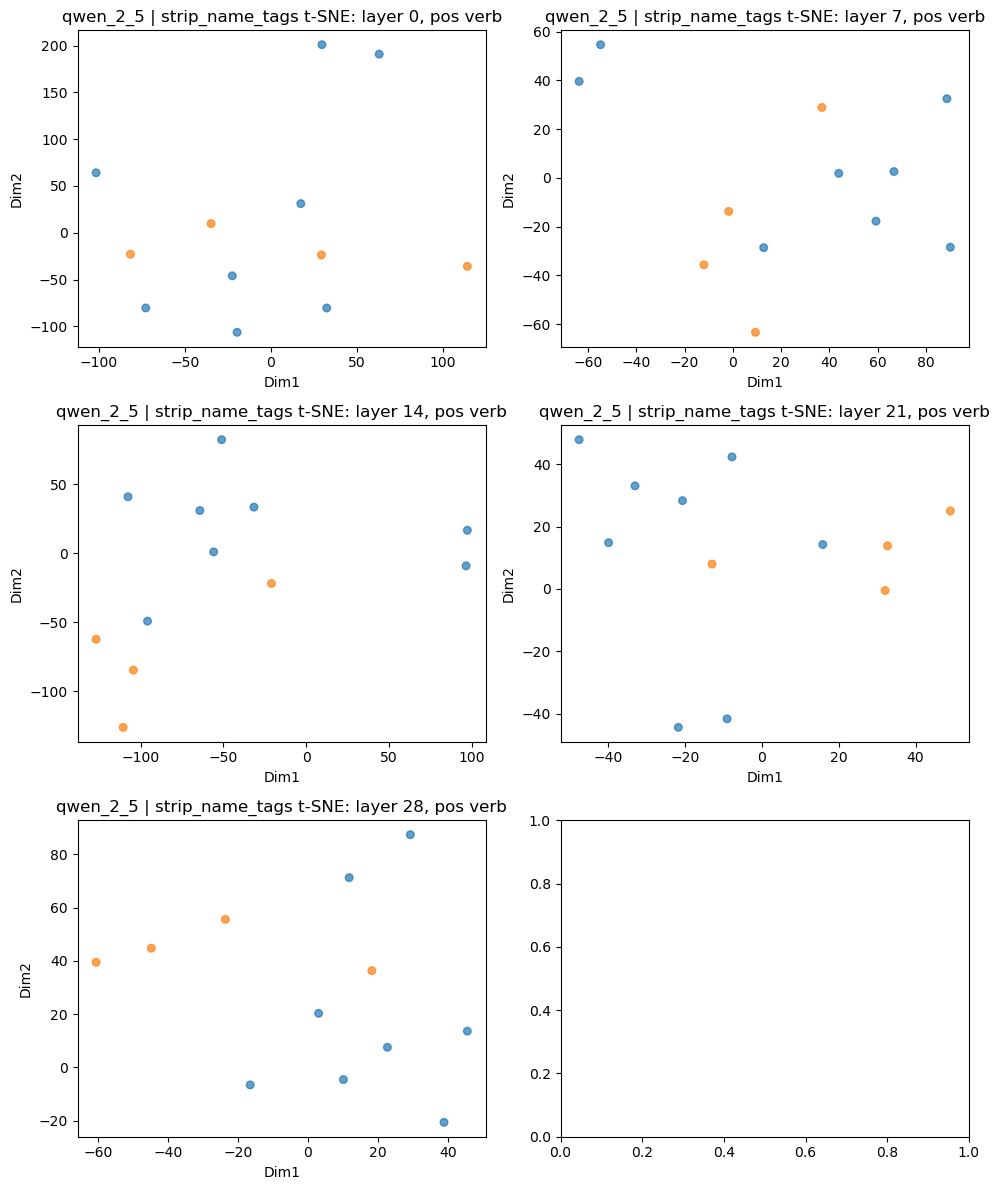

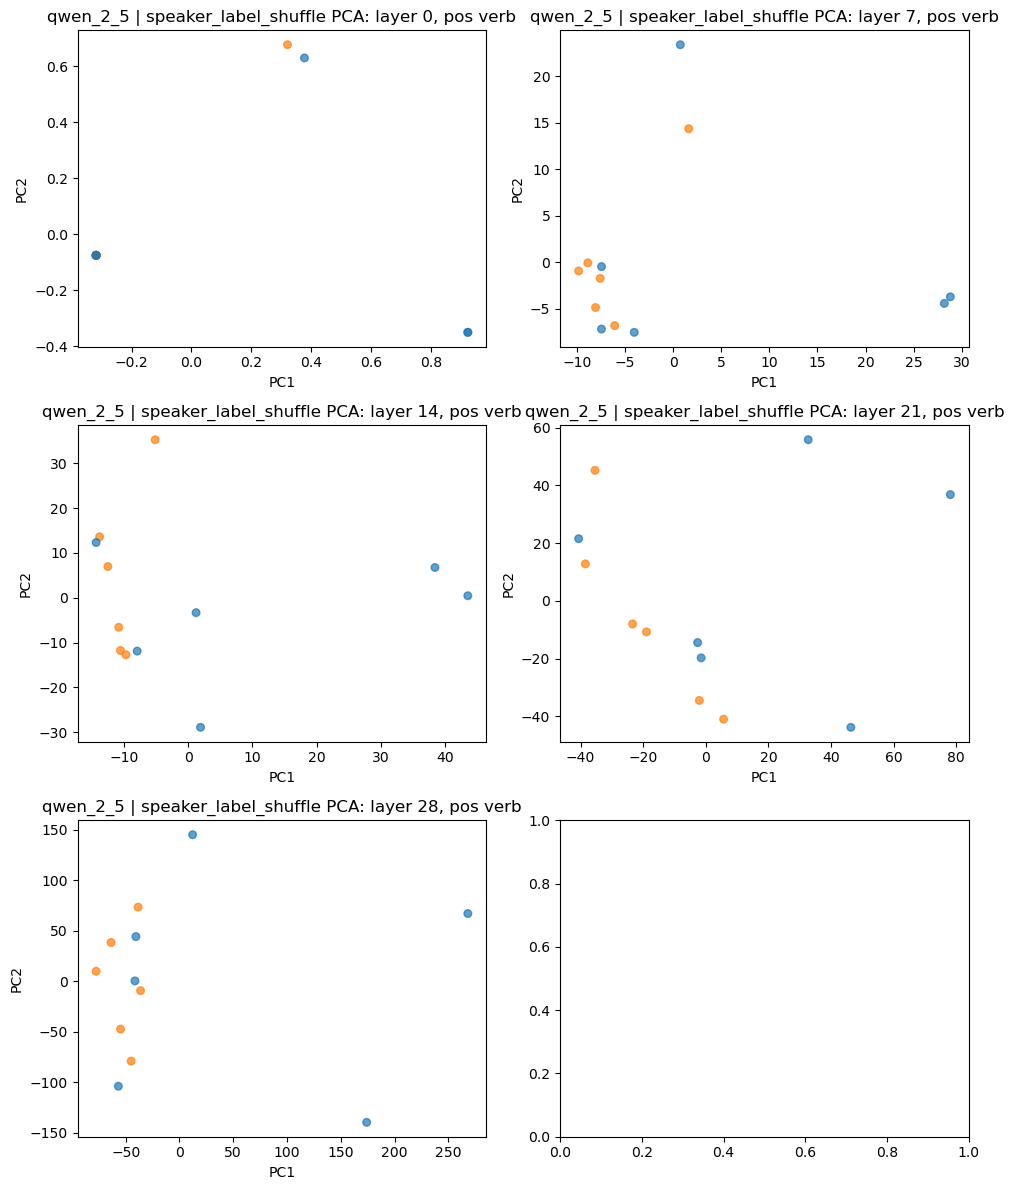

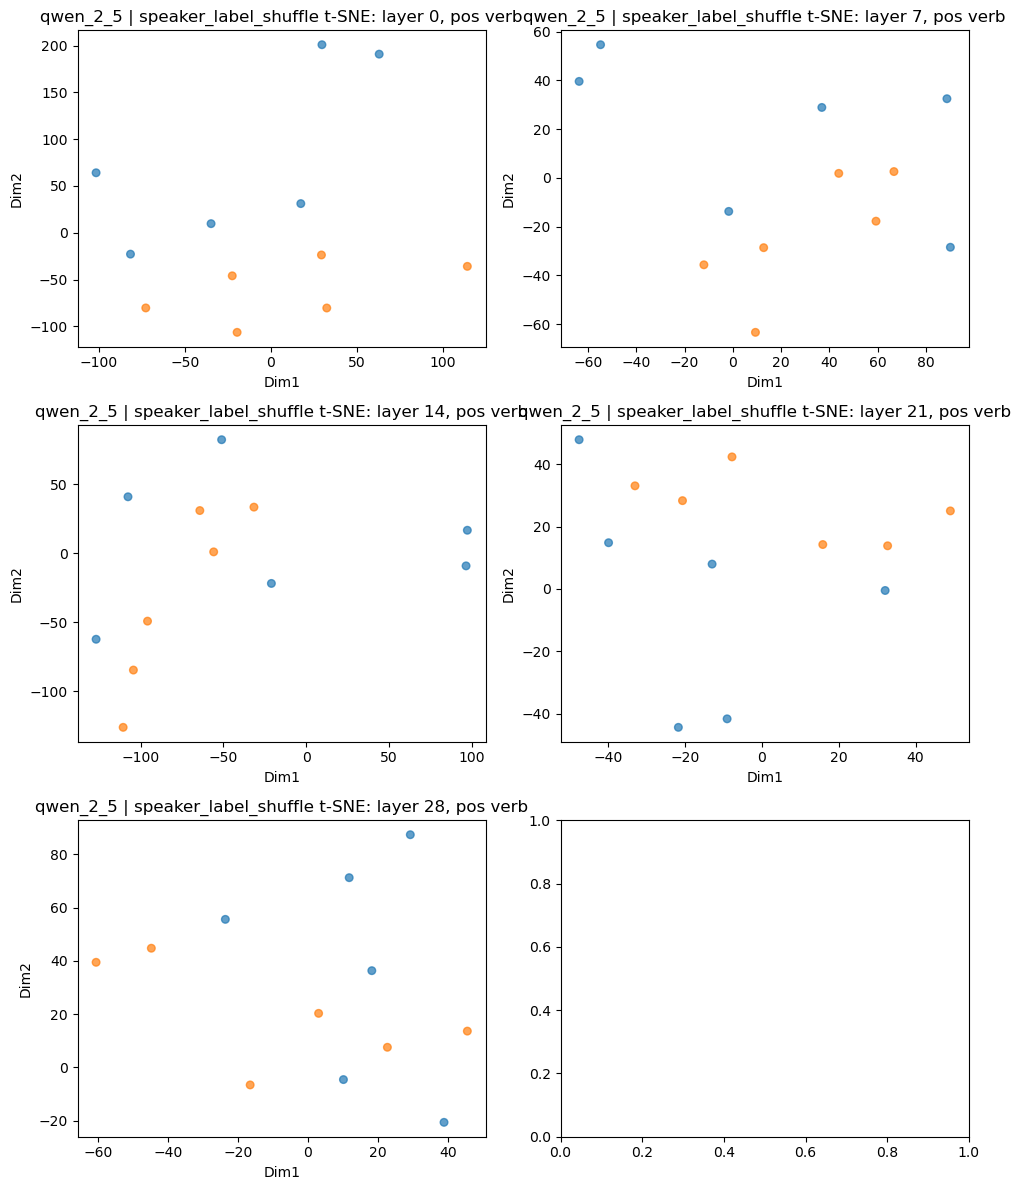

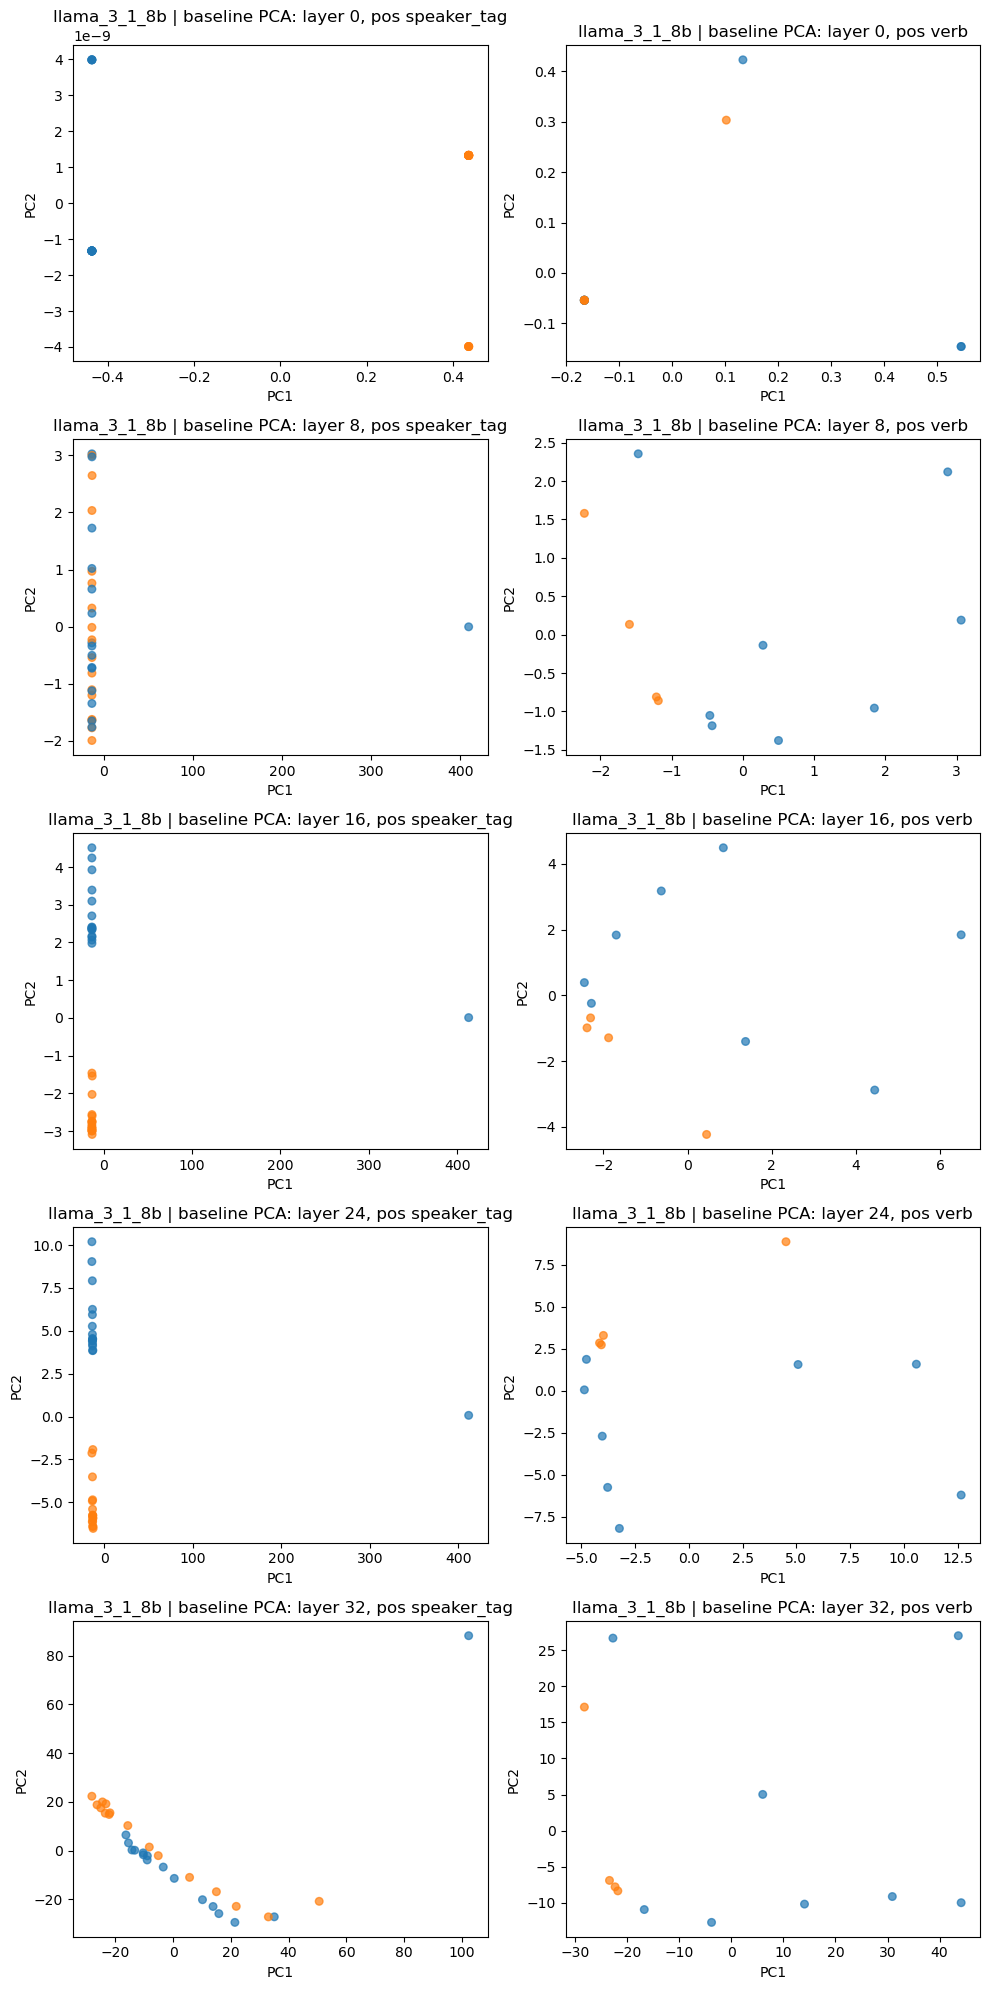

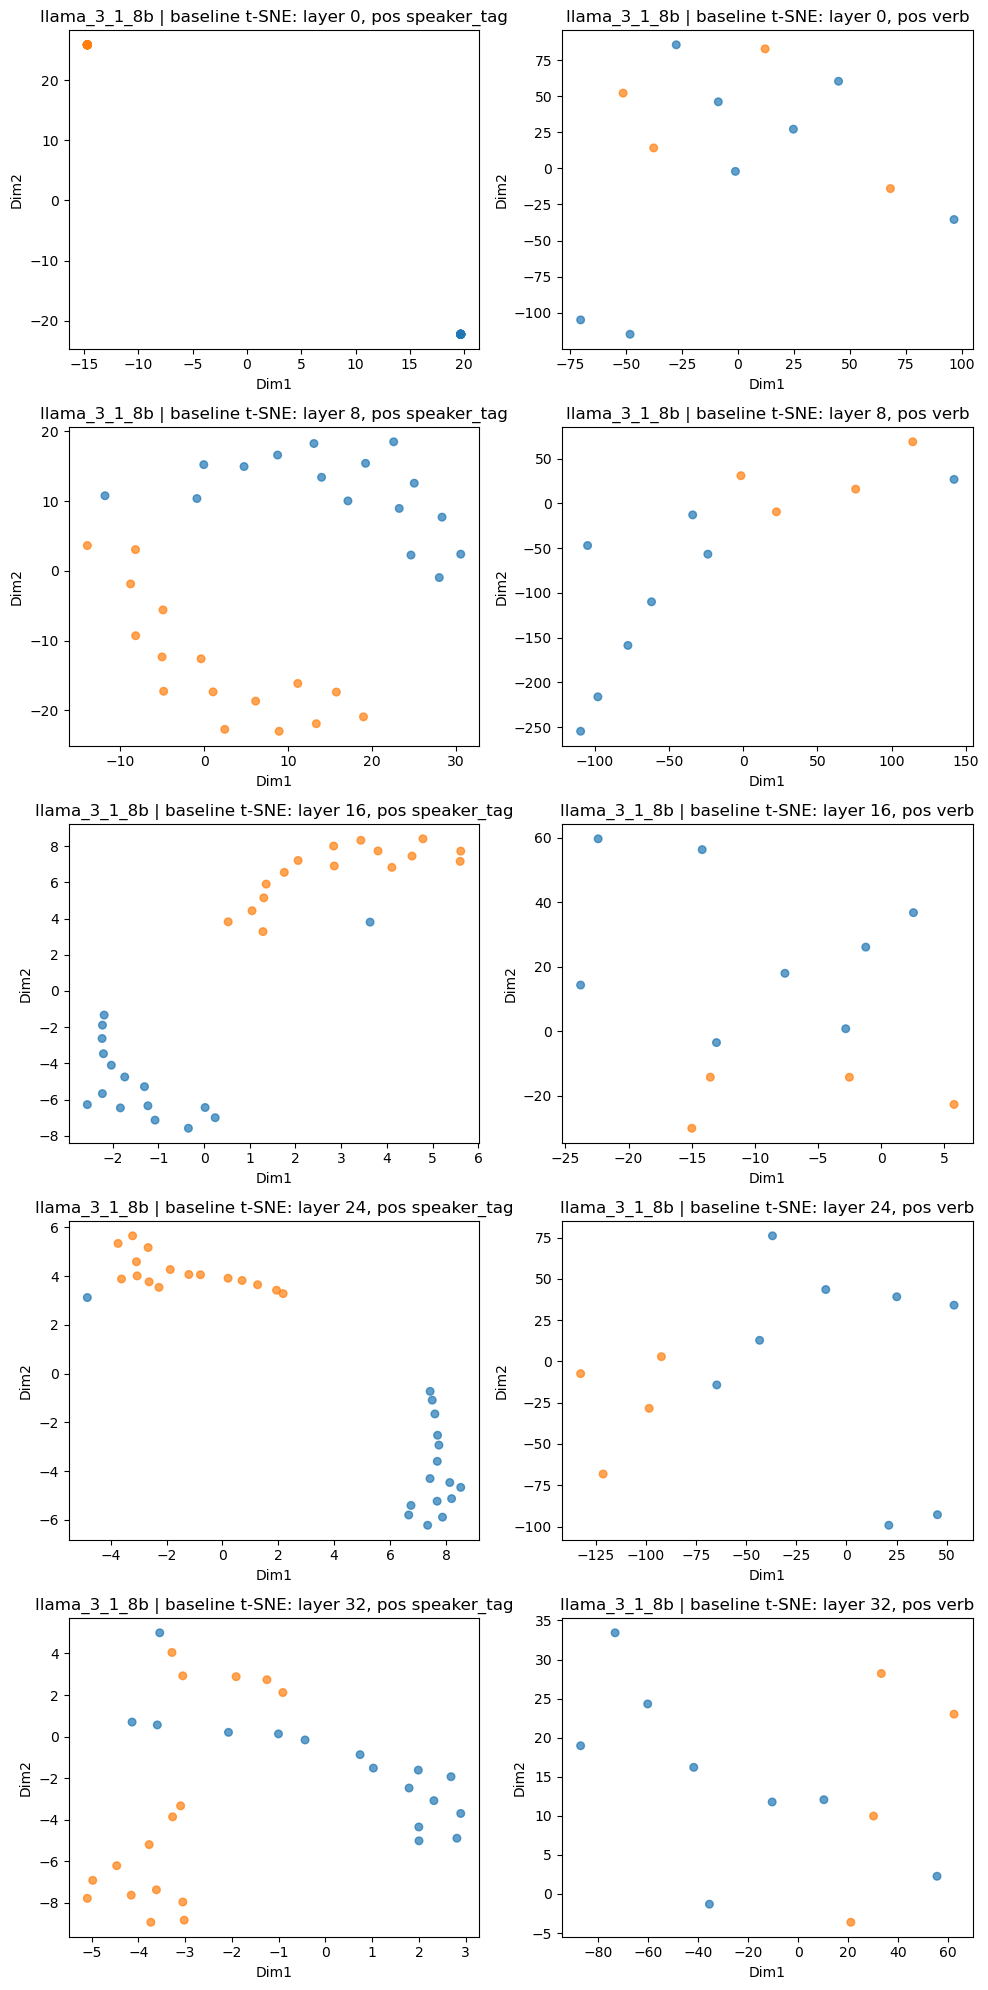

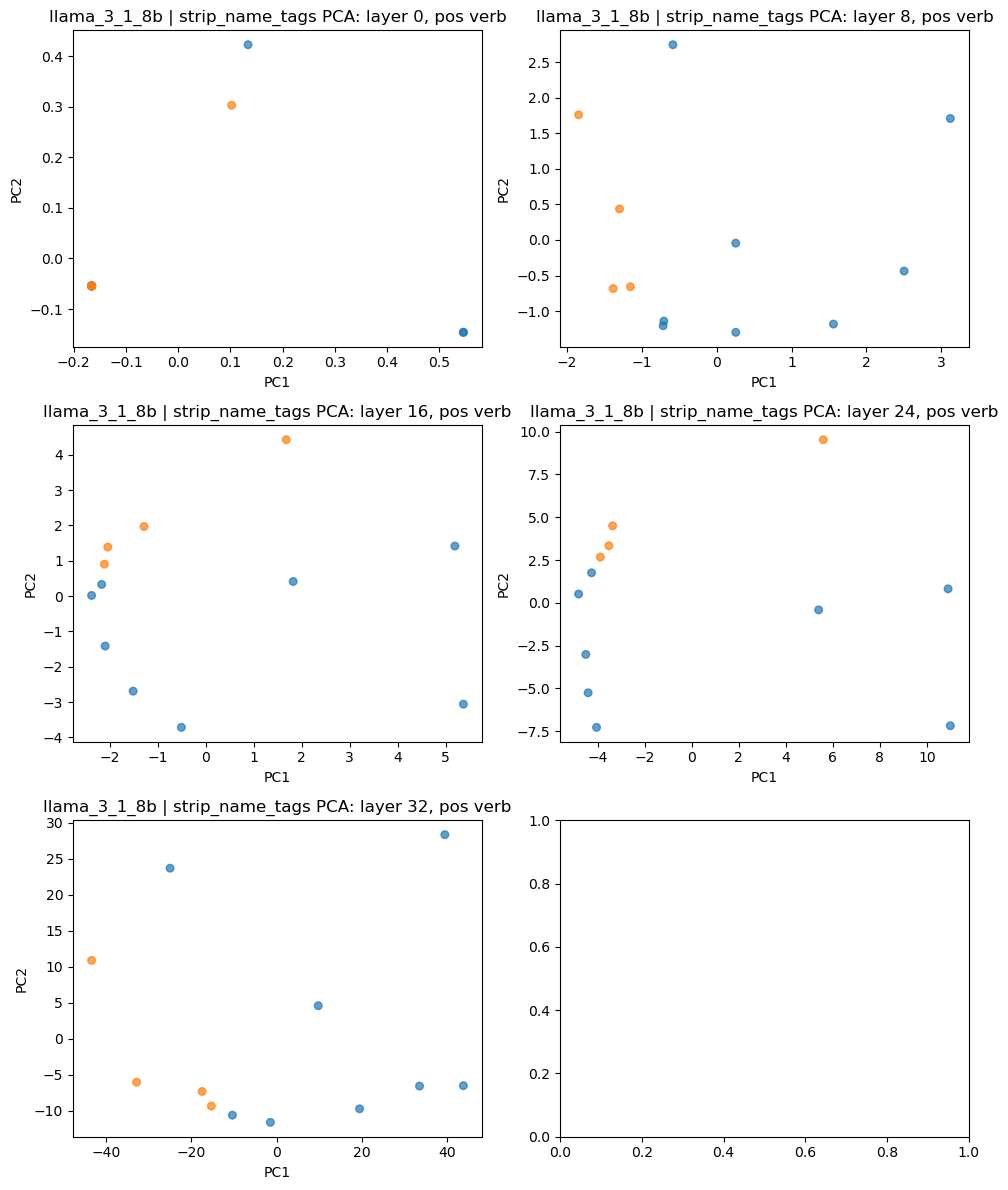

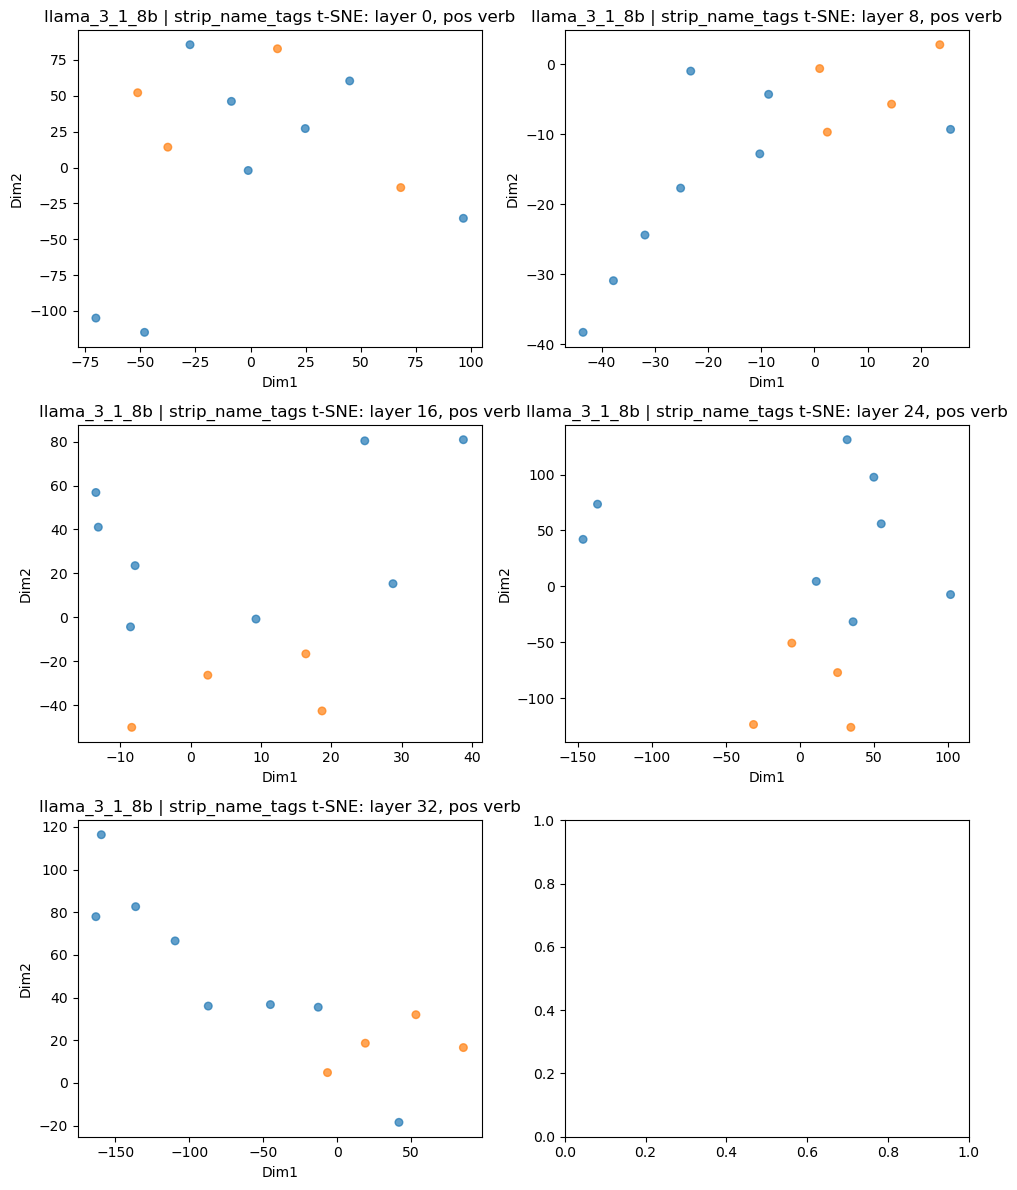

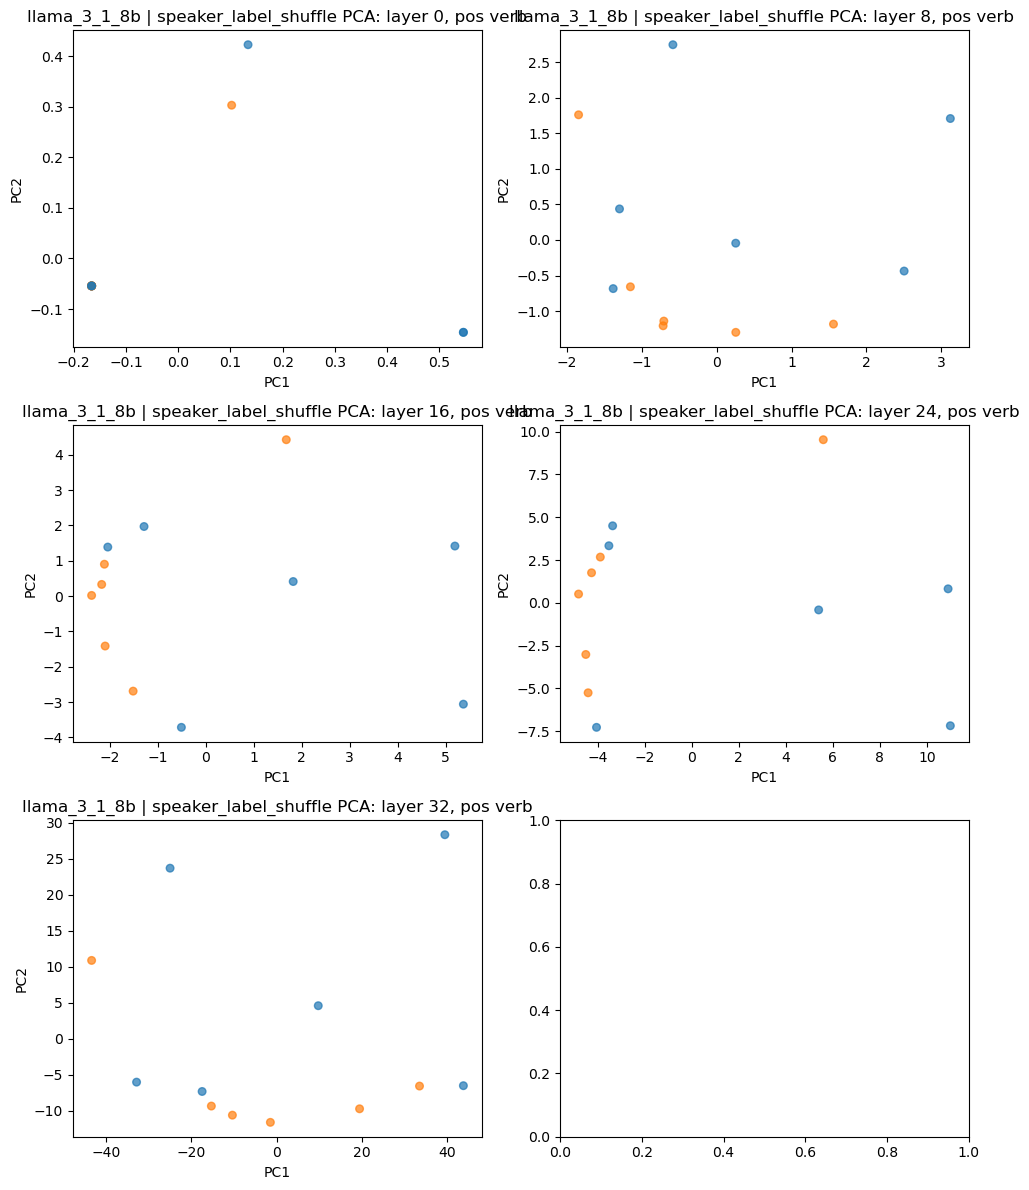

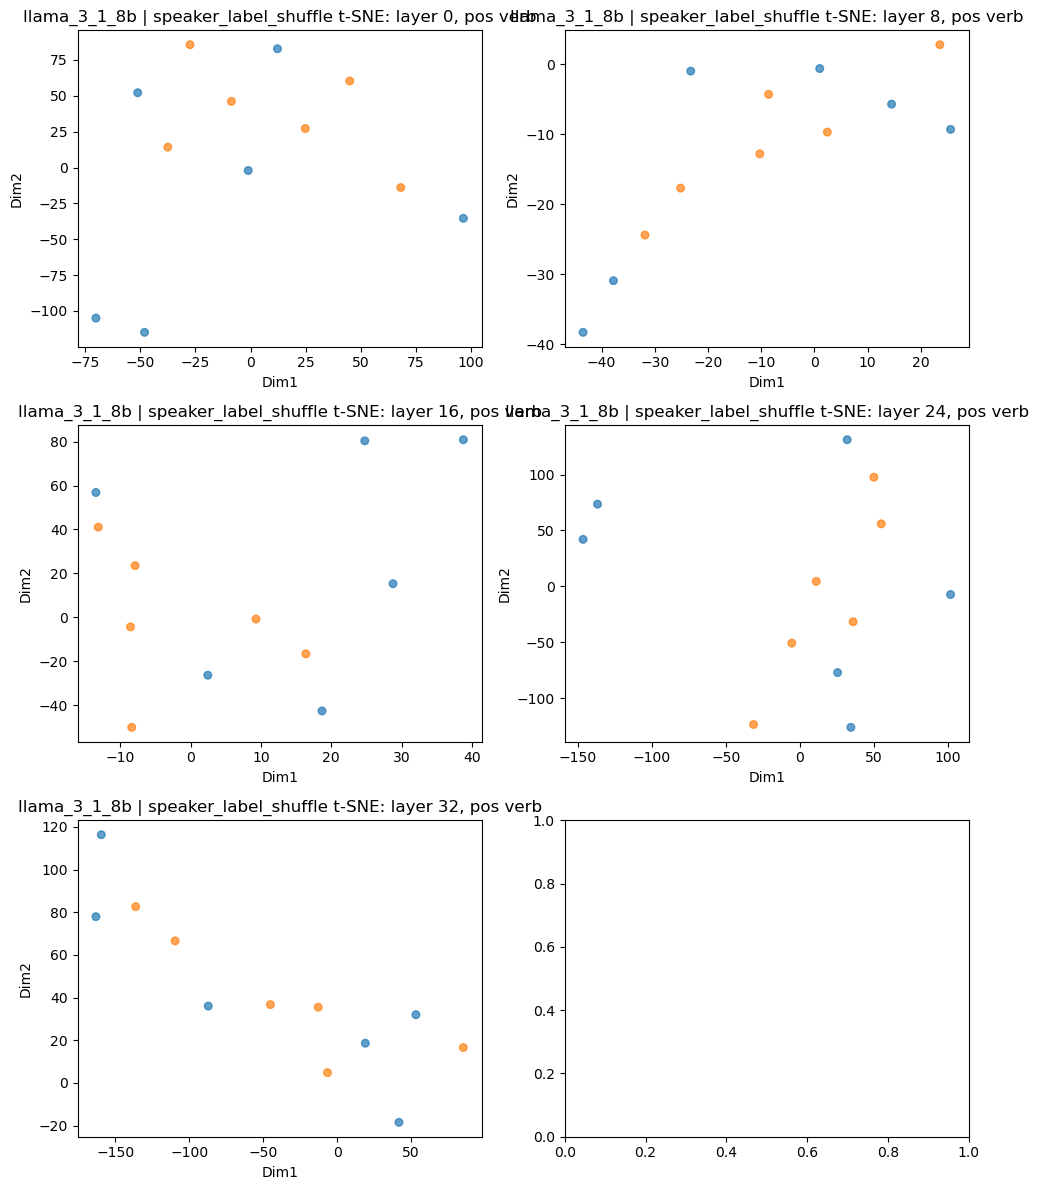

In [9]:
def plot_pca_tsne(tag: str, res: Dict):
    plots = []
    for (layer, pos_name), (X, y) in res["data"].items():
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        tsne = TSNE(
            n_components=2,
            perplexity=min(10, max(2, len(X) // 3)),
            init="random",
            random_state=7,
        )
        X_tsne = tsne.fit_transform(X)

        plots.append(((layer, pos_name), X_pca, X_tsne, y))

    if not plots:
        print(f"No plots for {tag}")
        return

    cols = 2
    rows = math.ceil(len(plots) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))
    if rows == 1:
        axes = np.array([axes])

    for ax, ((layer, pos_name), X_pca, _, y) in zip(axes.flatten(), plots):
        colors = np.where(y == "Alice", "tab:blue", "tab:orange")
        ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.7, s=30)
        ax.set_title(f"{tag} PCA: layer {layer}, pos {pos_name}")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")

    plt.tight_layout()
    plt.show()

    # t-SNE plots separately (can be slow)
    cols = 2
    rows = math.ceil(len(plots) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))
    if rows == 1:
        axes = np.array([axes])

    for ax, ((layer, pos_name), _, X_tsne, y) in zip(axes.flatten(), plots):
        colors = np.where(y == "Alice", "tab:blue", "tab:orange")
        ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.7, s=30)
        ax.set_title(f"{tag} t-SNE: layer {layer}, pos {pos_name}")
        ax.set_xlabel("Dim1")
        ax.set_ylabel("Dim2")

    plt.tight_layout()
    plt.show()


# Plot only a small subset by default (PCA/t-SNE can be slow/noisy for many variants).
PLOT_VARIANTS = ["baseline", "strip_name_tags", "speaker_label_shuffle"]

for model_key, variant_dict in results.items():
    for variant_key, res in variant_dict.items():
        if variant_key not in PLOT_VARIANTS:
            continue
        plot_pca_tsne(f"{model_key} | {variant_key}", res)


,model,variant,layer,position,accuracy
100,llama_3_1_8b,baseline,0,speaker_tag,1.000000
102,llama_3_1_8b,baseline,8,speaker_tag,0.966667
104,llama_3_1_8b,baseline,16,speaker_tag,0.966667
106,llama_3_1_8b,baseline,24,speaker_tag,0.966667
108,llama_3_1_8b,baseline,32,speaker_tag,1.000000
...,...,...,...,...,...
30,qwen_7b,turn_shuffle_within_speaker,0,verb,0.666667
31,qwen_7b,turn_shuffle_within_speaker,7,verb,0.583333
32,qwen_7b,turn_shuffle_within_speaker,14,verb,0.583333
33,qwen_7b,turn_shuffle_within_speaker,21,verb,0.583333


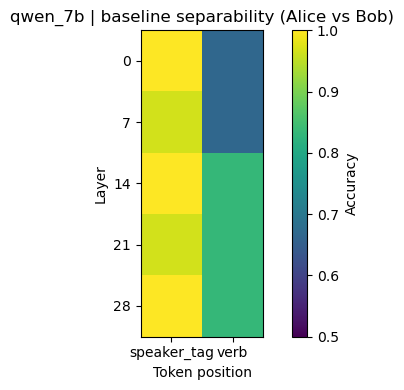

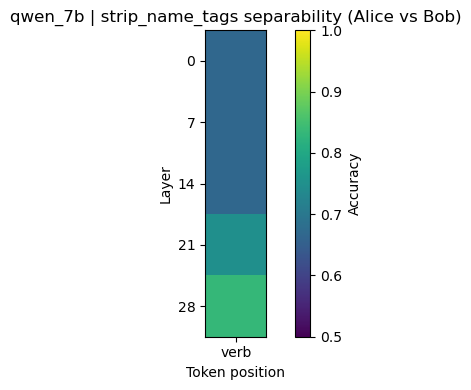

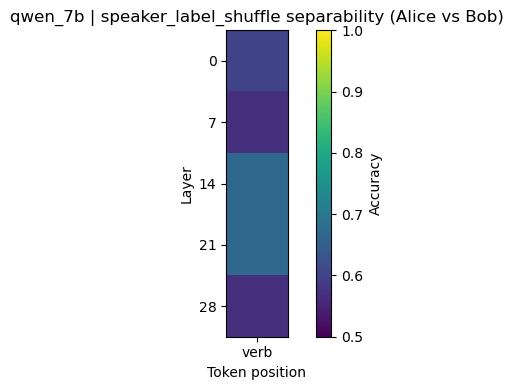

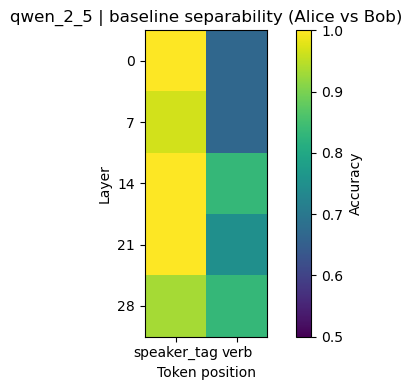

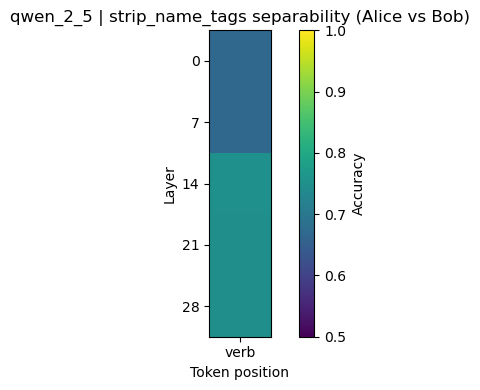

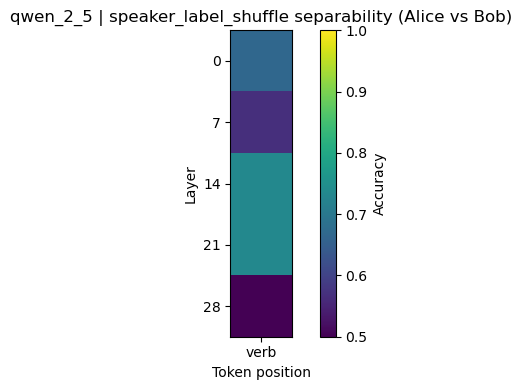

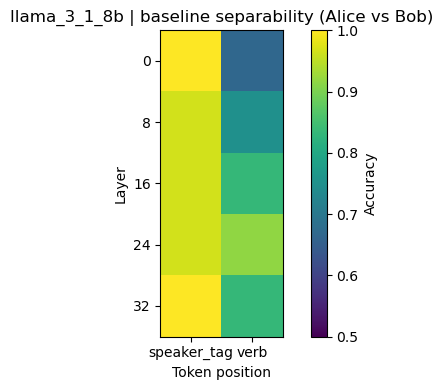

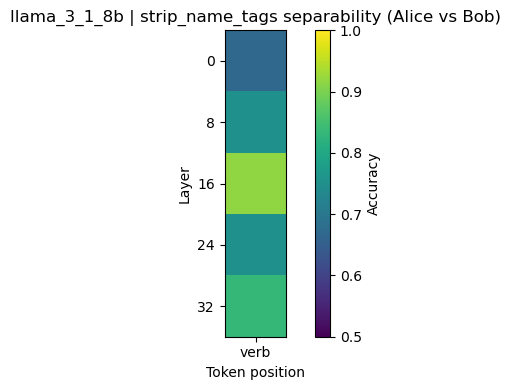

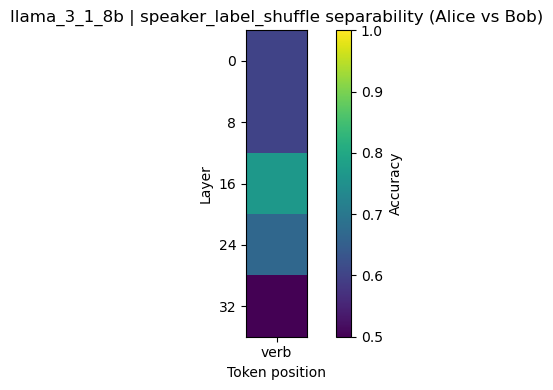

In [10]:
def compute_separability(res: Dict) -> pd.DataFrame:
    rows = []
    for (layer, pos_name), (X, y) in res["data"].items():
        y_bin = (y == "Alice").astype(int)

        # Skip degenerate cases (only one class present)
        classes, counts = np.unique(y_bin, return_counts=True)
        if len(classes) < 2:
            continue
        if counts.min() < 2:
            continue

        n_splits = min(5, int(counts.min()))
        if n_splits < 2:
            continue

        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7)
        accs = []
        for train_idx, test_idx in cv.split(X, y_bin):
            # Extra safety: some folds can still collapse if extremely imbalanced
            if len(np.unique(y_bin[train_idx])) < 2 or len(np.unique(y_bin[test_idx])) < 2:
                continue
            clf = LogisticRegression(max_iter=1000)
            clf.fit(X[train_idx], y_bin[train_idx])
            preds = clf.predict(X[test_idx])
            accs.append(accuracy_score(y_bin[test_idx], preds))

        if not accs:
            continue

        rows.append({"layer": layer, "position": pos_name, "accuracy": float(np.mean(accs))})

    return pd.DataFrame(rows)


def plot_heatmap(tag: str, df: pd.DataFrame):
    if df.empty:
        print(f"No separability data for {tag}")
        return
    pivot = df.pivot(index="layer", columns="position", values="accuracy")
    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(pivot.values, cmap="viridis", vmin=0.5, vmax=1.0)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_title(f"{tag} separability (Alice vs Bob)")
    ax.set_xlabel("Token position")
    ax.set_ylabel("Layer")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Accuracy")
    plt.tight_layout()
    plt.show()


# Compute separability for every (model, variant)
frames = []
for model_key, variant_dict in results.items():
    for variant_key, res in variant_dict.items():
        df = compute_separability(res)
        if df.empty:
            continue
        df.insert(0, "variant", variant_key)
        df.insert(0, "model", model_key)
        frames.append(df)

separability_all = (
    pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(columns=["model", "variant", "layer", "position", "accuracy"])
)

# Display as a long table (easy to filter/group)
display(separability_all.sort_values(["model", "variant", "position", "layer"]))

# Heatmaps for a small subset by default
HEATMAP_VARIANTS = ["baseline", "strip_name_tags", "speaker_label_shuffle"]
for model_key, variant_dict in results.items():
    for variant_key in HEATMAP_VARIANTS:
        if variant_key not in variant_dict:
            continue
        df = separability_all[(separability_all.model == model_key) & (separability_all.variant == variant_key)]
        plot_heatmap(f"{model_key} | {variant_key}", df)


,model,variant,layer,position,accuracy
100,llama_3_1_8b,baseline,0,speaker_tag,1.000000
102,llama_3_1_8b,baseline,8,speaker_tag,0.937500
104,llama_3_1_8b,baseline,16,speaker_tag,1.000000
106,llama_3_1_8b,baseline,24,speaker_tag,1.000000
108,llama_3_1_8b,baseline,32,speaker_tag,1.000000
...,...,...,...,...,...
30,qwen_7b,turn_shuffle_within_speaker,0,verb,0.583333
31,qwen_7b,turn_shuffle_within_speaker,7,verb,0.833333
32,qwen_7b,turn_shuffle_within_speaker,14,verb,0.833333
33,qwen_7b,turn_shuffle_within_speaker,21,verb,0.833333


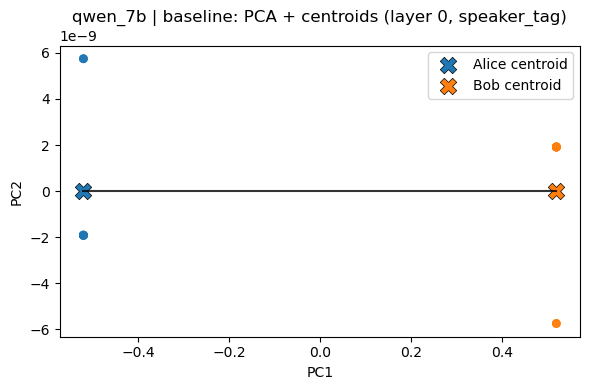

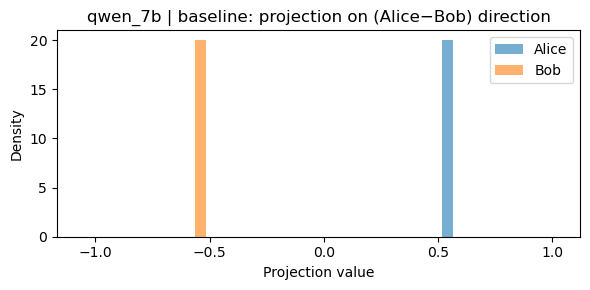

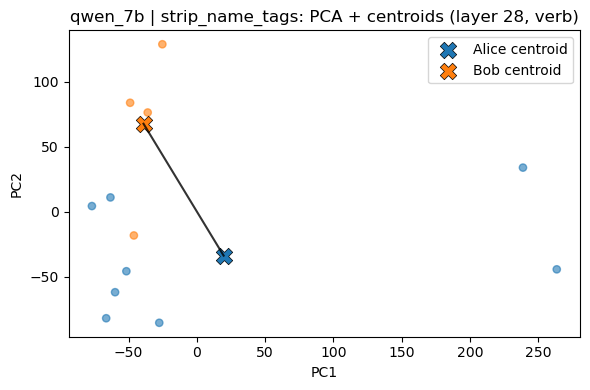

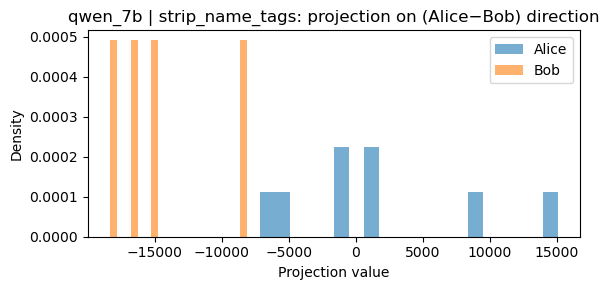

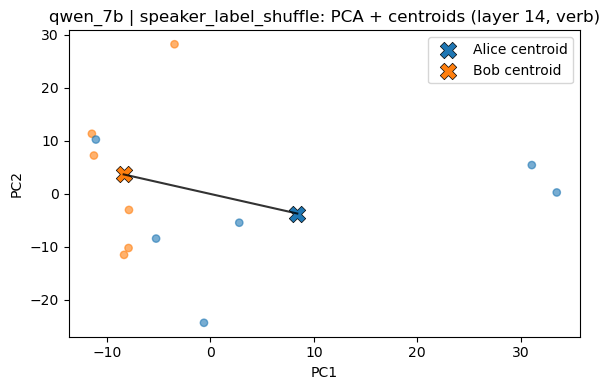

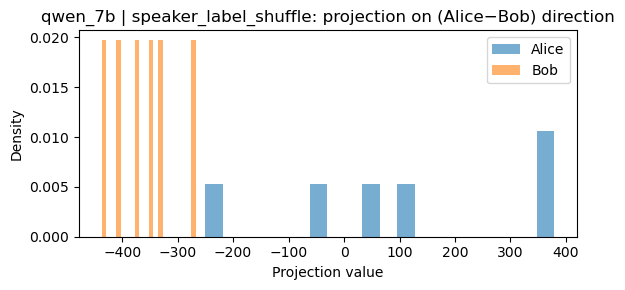

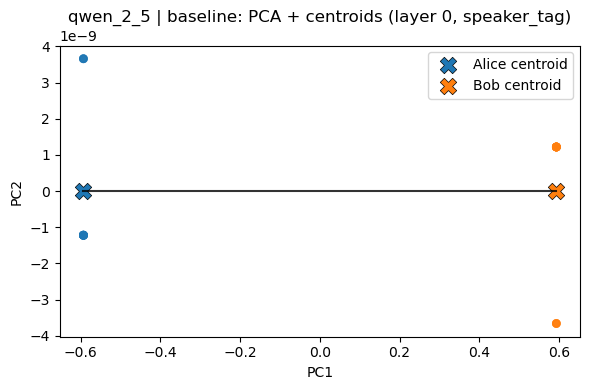

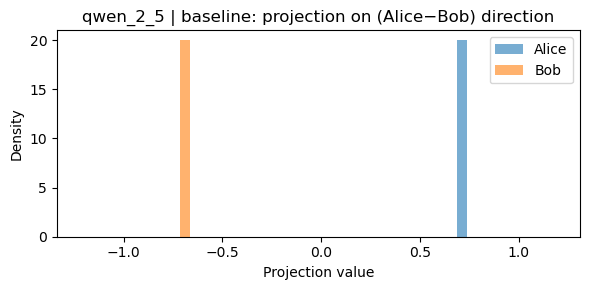

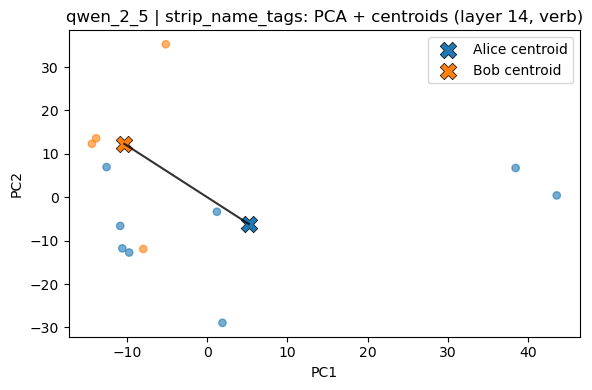

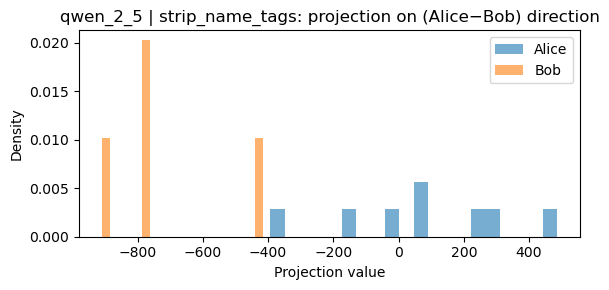

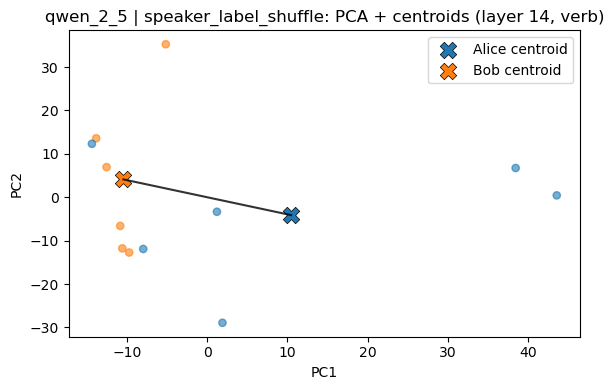

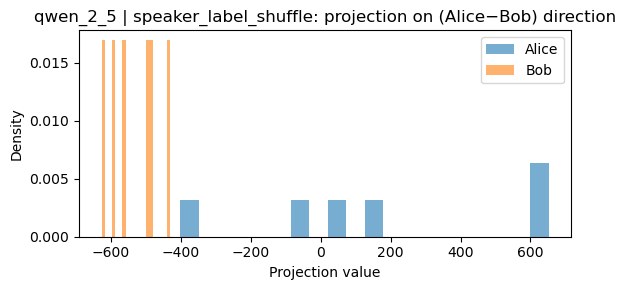

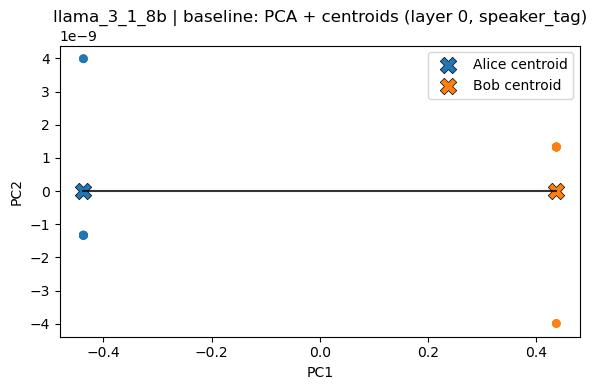

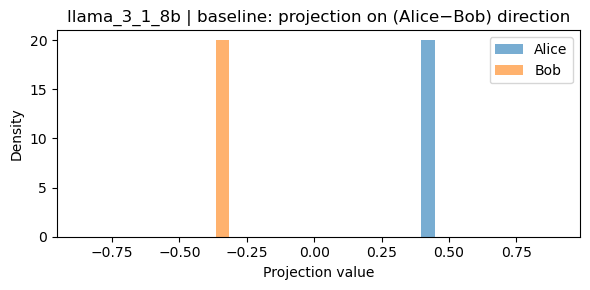

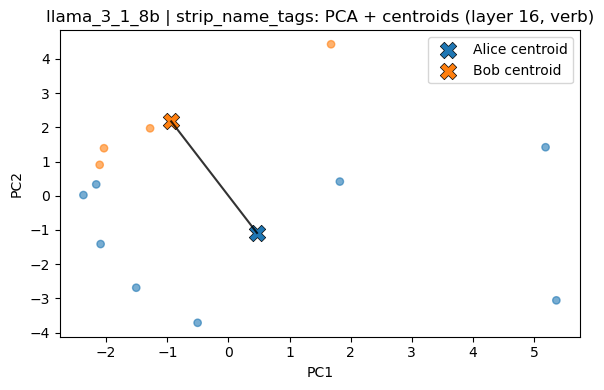

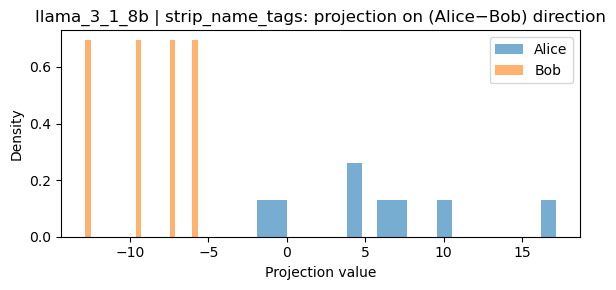

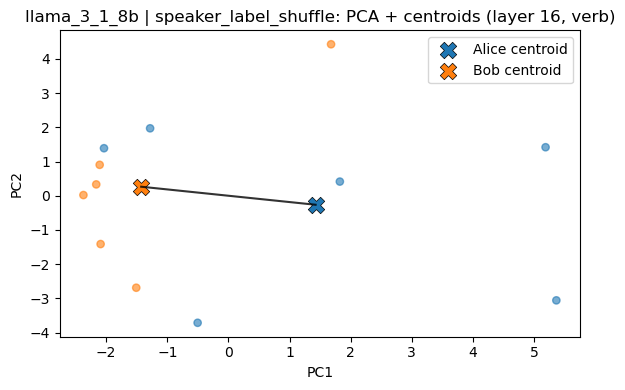

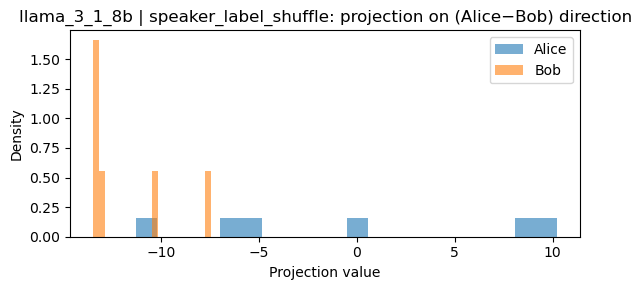

In [11]:
def mean_difference_direction(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    alice_mean = X[y == "Alice"].mean(axis=0)
    bob_mean = X[y == "Bob"].mean(axis=0)
    return alice_mean - bob_mean


def concept_direction_eval(res: Dict) -> pd.DataFrame:
    rows = []
    for (layer, pos_name), (X, y) in res["data"].items():
        # Skip degenerate cases
        if len(set(y.tolist())) < 2:
            continue
        direction = mean_difference_direction(X, y)
        proj = X @ direction
        threshold = np.median(proj)
        preds = (proj > threshold).astype(int)
        acc = accuracy_score((y == "Alice").astype(int), preds)
        rows.append({"layer": layer, "position": pos_name, "accuracy": float(acc)})
    return pd.DataFrame(rows)


def plot_concept_pca(tag: str, res: Dict):
    """More interpretable than an arrow: show class centroids + projection hist."""
    df = compute_separability(res)
    if df.empty:
        return

    best = df.sort_values("accuracy", ascending=False).iloc[0]
    layer = int(best["layer"])
    pos_name = best["position"]
    X, y = res["data"][(layer, pos_name)]

    direction = mean_difference_direction(X, y)
    proj = X @ direction

    # PCA scatter with centroids
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    colors = np.where(y == "Alice", "tab:blue", "tab:orange")
    plt.figure(figsize=(6, 4))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6, s=28)

    # Centroids in PCA space
    alice_cent = X_pca[y == "Alice"].mean(axis=0)
    bob_cent = X_pca[y == "Bob"].mean(axis=0)
    plt.scatter(
        [alice_cent[0]],
        [alice_cent[1]],
        c="tab:blue",
        s=140,
        marker="X",
        edgecolor="k",
        linewidth=0.5,
        label="Alice centroid",
    )
    plt.scatter(
        [bob_cent[0]],
        [bob_cent[1]],
        c="tab:orange",
        s=140,
        marker="X",
        edgecolor="k",
        linewidth=0.5,
        label="Bob centroid",
    )

    # Line connecting centroids (visual "axis" in PCA plane)
    plt.plot([alice_cent[0], bob_cent[0]], [alice_cent[1], bob_cent[1]], color="k", linewidth=1.5, alpha=0.8)

    plt.title(f"{tag}: PCA + centroids (layer {layer}, {pos_name})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

    # 1D projection histogram along concept direction
    plt.figure(figsize=(6, 3))
    plt.hist(proj[y == "Alice"], bins=20, alpha=0.6, label="Alice", color="tab:blue", density=True)
    plt.hist(proj[y == "Bob"], bins=20, alpha=0.6, label="Bob", color="tab:orange", density=True)
    plt.title(f"{tag}: projection on (Alice−Bob) direction")
    plt.xlabel("Projection value")
    plt.ylabel("Density")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


# Compute concept-direction accuracy for every (model, variant)
frames = []
for model_key, variant_dict in results.items():
    for variant_key, res in variant_dict.items():
        df = concept_direction_eval(res)
        if df.empty:
            continue
        df.insert(0, "variant", variant_key)
        df.insert(0, "model", model_key)
        frames.append(df)

concept_all = (
    pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(columns=["model", "variant", "layer", "position", "accuracy"])
)

display(concept_all.sort_values(["model", "variant", "position", "layer"]))

CONCEPT_VARIANTS = ["baseline", "strip_name_tags", "speaker_label_shuffle"]
for model_key, variant_dict in results.items():
    for variant_key in CONCEPT_VARIANTS:
        if variant_key not in variant_dict:
            continue
        plot_concept_pca(f"{model_key} | {variant_key}", variant_dict[variant_key])


In [12]:
from pathlib import Path
import json
import numpy as np

out_dir = Path("outputs/geometric_structure")
out_dir.mkdir(parents=True, exist_ok=True)

summary = {}  # model_key -> variant_key -> paths

for model_key, variant_dict in results.items():
    summary[model_key] = {}

    for variant_key, res in variant_dict.items():
        # res["data"] maps (layer, position) -> (X, y)
        arrays = {}
        meta = {
            "model_key": model_key,
            "model_name": res.get("model_name"),
            "variant_key": variant_key,
            "variant_notes": VARIANTS.get(variant_key, {}).get("notes"),
            "layers": [int(x) for x in res.get("layers", [])],
            "positions": {k: [int(i) for i in v] for k, v in res.get("positions", {}).items()},
        }

        for (layer, pos_name), (X, y) in res["data"].items():
            k = f"layer{int(layer)}__pos{pos_name}"
            arrays[f"{k}__X"] = X.astype(np.float32)
            arrays[f"{k}__y"] = y.astype(str)

        stem = f"{model_key}__{variant_key}"
        npz_path = out_dir / f"{stem}_layerpos_data.npz"
        np.savez_compressed(npz_path, **arrays)

        meta_path = out_dir / f"{stem}_meta.json"
        meta_path.write_text(json.dumps(meta, indent=2))

        summary[model_key][variant_key] = {
            "npz": str(npz_path),
            "meta": str(meta_path),
            "num_layerpos": len(res["data"]),
        }

(out_dir / "SUMMARY.json").write_text(json.dumps(summary, indent=2))
print("Saved to:", out_dir.resolve())
print(json.dumps(summary, indent=2))

Saved to: /projects/JeFeSpace/KLM/repos/role-representation/speaker-tracking/notebooks/outputs/geometric_structure
{
  "qwen_7b": {
    "baseline": {
      "npz": "outputs/geometric_structure/qwen_7b__baseline_layerpos_data.npz",
      "meta": "outputs/geometric_structure/qwen_7b__baseline_meta.json",
      "num_layerpos": 10
    },
    "strip_name_tags": {
      "npz": "outputs/geometric_structure/qwen_7b__strip_name_tags_layerpos_data.npz",
      "meta": "outputs/geometric_structure/qwen_7b__strip_name_tags_meta.json",
      "num_layerpos": 5
    },
    "mask_name_tags": {
      "npz": "outputs/geometric_structure/qwen_7b__mask_name_tags_layerpos_data.npz",
      "meta": "outputs/geometric_structure/qwen_7b__mask_name_tags_meta.json",
      "num_layerpos": 5
    },
    "speaker_label_shuffle": {
      "npz": "outputs/geometric_structure/qwen_7b__speaker_label_shuffle_layerpos_data.npz",
      "meta": "outputs/geometric_structure/qwen_7b__speaker_label_shuffle_meta.json",
      "num_l

## Write-up Template (fill after running)

**Key observations**
- Which layer shows the clearest Alice/Bob separation?
- Which position (speaker tags vs verbs vs final token) carries the cleanest signal?
- Do Qwen and Llama differ in where the signal peaks?

**Interpretation**
- Does the representation look linearly separable (high accuracy), or more diffuse?
- Is speaker identity localized to specific positions or distributed?
- Does speaker identity emerge late (higher layers) or early?
